<a href="https://colab.research.google.com/github/kikiymini/7506R-1C2024-GRUPO02/blob/main/7506R_1C2024_GRUPO02_N1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>

<font color='red'>Agregar a la carpeta 7506R-1C2024-GRUPO02 QUE TENGO EN DRIVE el archivo barrio.csv Descargarlo de acá [GCBA](https://data.buenosaires.gob.ar/dataset/barrios/resource/juqdkmgo-191-resource) y subirlo a carpeta /Dataset</font>

#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1: Propiedades en venta</center>

### <center> Grupo 2</center>

## Integrantes:

*   Aramayo Carolina
*   Utrera Maximo Damian
*   Villalba Ana Daniela
*   Fiorilo Roy


# Importación de librerias

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon, Point

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import silhouette_score

# Lectura de archivo

### Desde google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/7506R-1C2024-GRUPO02/Dataset/properati_argentina_2021.csv'
barrios_file = '/content/drive/MyDrive/7506R-1C2024-GRUPO02/Dataset/barrios.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


### Desde maquina local

In [3]:
# Si se esta trabajando en local, descomentar esta celta y comentar la de arriba
# file_path = './dataset/properati_argentina_2021.csv'
# barrios_file = './dataset/barrios.csv'
# df = pd.read_csv(file_path)

In [4]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


# Análisis Exploratorio y Pre-procesamiento de Datos

En esta sección vamos a filtrar y seleccionar los datos a trabajar a lo largo del proyecto.




#### Filtrado

Se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

En la etapa de filtrado, vamos a utilizar la funcionalidad de `str.contains()` de pandas. Este código se basa en la documentación oficial de pandas que puedes encontrar en [este enlace](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html).


In [5]:
# filtro por tipo de propiedad
# str.contains() se utiliza para buscar patrones de texto dentro de las cadenas en una serie.
# USD: indica el patrón que busco
# case: no distingue entre mayúsculas y minúsculas
# na: no registro valores NaN
filtro = df.property_type.str.contains('Casa|PH|Departamento',case=False,na=False)
ds_propiedades_filtradas = df[filtro]
ds_propiedades_filtradas = ds_propiedades_filtradas[~ds_propiedades_filtradas['property_type'].str.contains('Casa de campo')]

In [6]:
# filtro propiedades en Capital Federal
filtro = ds_propiedades_filtradas.place_l2.str.contains('Capital Federal',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [7]:
# filtro propiedades en venta
filtro = ds_propiedades_filtradas.operation.str.contains('Venta',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [8]:
# filtro por moneda DÓLAR
filtro = ds_propiedades_filtradas.property_currency.str.contains('USD',case=False,na=False)
ds_propiedades_filtradas = ds_propiedades_filtradas[filtro]

In [9]:
# DataSet filtrado
ds_propiedades_filtradas.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,3.0,2.0,58.0,55.0,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,NaN,NaN,NaN,Venta,Departamento,4.0,3.0,70.0,70.0,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,NaN,NaN,NaN,Venta,Departamento,4.0,2.0,NaN,104.0,146000.0,USD,Venta departamento 4 ambientes Once
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,NaN,NaN,NaN,Venta,PH,4.0,2.0,NaN,73.0,250000.0,USD,PH - Boedo


#### Sets de entrenamiento y test

Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

En esta sección se utiliza el método `train_test_split()` de Scikit-learn para dividir el conjunto de datos en conjuntos de entrenamiento y prueba. Este método es útil para evaluar el rendimiento de un modelo de aprendizaje automático.

El método `train_test_split()` se puede encontrar en la documentación oficial de Scikit-learn:

- [train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html)
- [Documentación de train_test_split() en Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)


In [10]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
prop_train, prop_test = train_test_split(ds_propiedades_filtradas, train_size=0.8)
print("Propiedades para entrenar:", len(prop_train))
print("Propiedades para testear:", len(prop_test))

Propiedades para entrenar: 75399
Propiedades para testear: 18850


## Exploración Inicial

### Medidas de resumen de las variables cuantitativas del Dataset

In [11]:
# Creo resumen con describe
ds_propieades_filtradas_resumen = ds_propiedades_filtradas.describe()
# Agrego moda a la tabla resumen
ds_propieades_filtradas_resumen.loc['mode'] = ds_propiedades_filtradas.mode().iloc[0]
ds_propieades_filtradas_resumen


,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,90519.000000,90519.000000,0.0,93205.000000,83262.000000,89405.000000,90895.000000,9.424900e+04
mean,-34.591481,-58.449795,NaN,2.822799,2.014629,109.092970,87.931932,2.262382e+05
std,0.181719,0.292630,NaN,1.426148,1.129767,980.401976,990.927129,3.186035e+05
min,-53.788624,-71.471192,NaN,1.000000,-1.000000,10.000000,1.000000,5.000000e+03
25%,-34.615975,-58.466522,NaN,2.000000,1.000000,45.000000,40.000000,9.500000e+04
50%,-34.595790,-58.439000,NaN,3.000000,2.000000,65.000000,58.000000,1.439000e+05
75%,-34.577413,-58.408862,NaN,4.000000,3.000000,105.000000,88.000000,2.370000e+05
max,-24.219827,-54.133330,NaN,40.000000,70.000000,137000.000000,217000.000000,2.140000e+07
mode,-34.541250,-58.472966,NaN,3.000000,1.000000,50.000000,40.000000,1.100000e+05


En esta tabla resumen se pueden apreciar (en orden):

* El recuento de las entradas validas por atributo.
* El mean de cada atributo.
* La desviacion estandar.
* El valor minimo de cada atributo.
* El percentil 25.
* El percentil 50.
* El percentil 75.
* El valor maximo de cada atributo.
* La moda de cada atributo.

### Cantidad de valores posibles para cada variable cualitativo

In [12]:
# Mostrar la cantidad de valores posibles para cada variable cualitativa
variables_cualitativas = [
    'property_type',
    'operation',
    'property_currency',
    'start_date',
    'end_date',
    'created_on',
    'place_l2',
    'place_l3',
    'place_l4',
    'place_l5',
    'place_l6',
    ]
ds_propiedades_filtradas[variables_cualitativas].nunique()

property_type          3
operation              1
property_currency      1
start_date           365
end_date             607
created_on           365
place_l2               1
place_l3              57
place_l4               4
place_l5               0
place_l6               0
dtype: int64

### Frecuencia de los valores posibles de variables cualitativas

En un grafico de barras se veran las frecuencias de los valores posibles para los atributos cualitativos mas importantes y donde hay mas de 1 alternativa, es decir no se tomara por ejemplo *place_l2* porque se sabe que por el filtro el 100% de los valores sera 'Capital Federal', asi mismo para *operation* que sera 'Venta' y *property_currency* que sera 'USD'.

* place_l3 (los 15 mas frecuentes)
* place_l4
* property_type

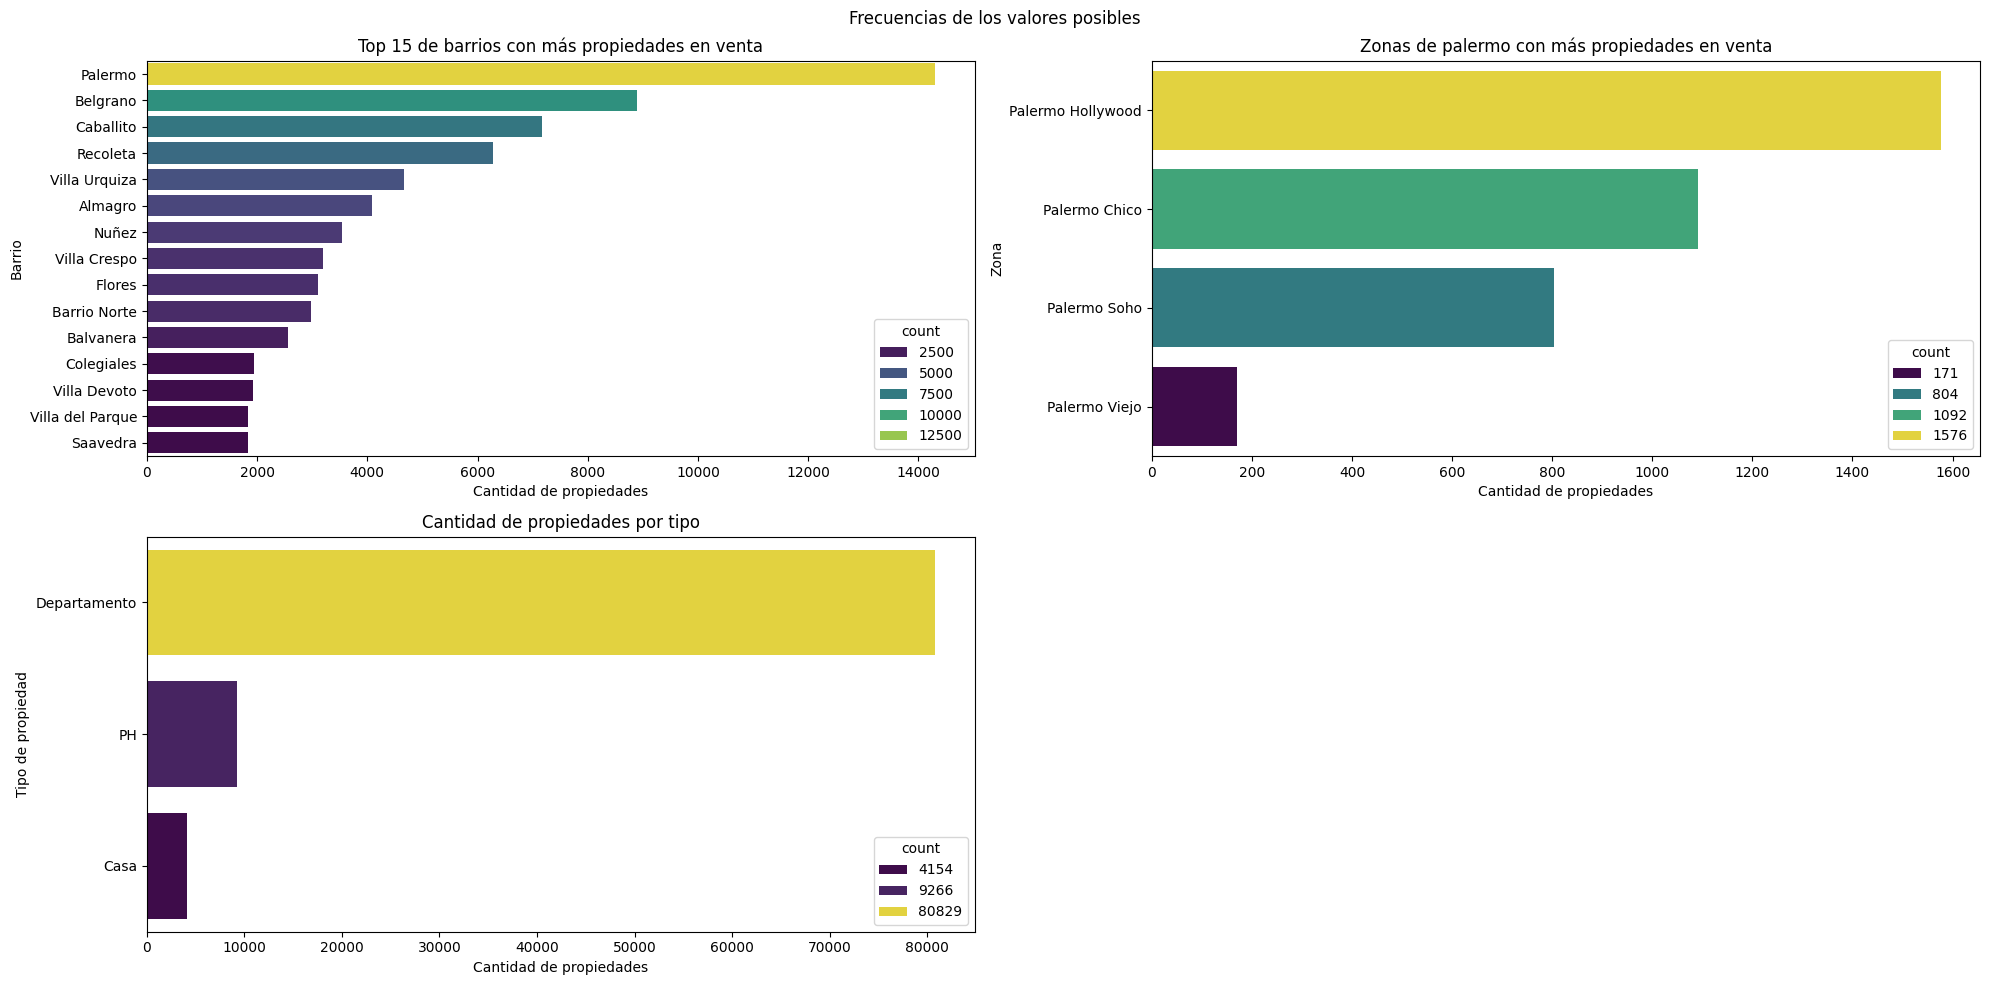

In [13]:
plt.figure(figsize=(20, 10)) # 10x10 inches
plt.suptitle('Frecuencias de los valores posibles')

# bar plot por place_l3
plt.subplot(2, 2, 1) # 2 filas, 2 columnas, 1 posicion
frecuencias_place_3 = ds_propiedades_filtradas["place_l3"].value_counts().head(15)
sns.barplot(x=frecuencias_place_3.values, y=frecuencias_place_3.index, hue=frecuencias_place_3, palette='viridis')
plt.title('Top 15 de barrios con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Barrio')

# bar plot por place_l4
plt.subplot(2, 2, 2) # 2 filas, 2 columnas, 2 posicion
frecuencias_place_4 = ds_propiedades_filtradas["place_l4"].value_counts()
sns.barplot(x=frecuencias_place_4.values, y=frecuencias_place_4.index, hue=frecuencias_place_4, palette='viridis')
# Ya que los 4 valores posibles pertenecen a Palermo
plt.title('Zonas de palermo con más propiedades en venta')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Zona')

# bar plot por property_type
plt.subplot(2, 2, 3) # 2 filas, 2 columnas, 3 posicion
frecuencias_property_type = ds_propiedades_filtradas["property_type"].value_counts()
sns.barplot(x=frecuencias_property_type.values, y=frecuencias_property_type.index, hue=frecuencias_property_type, palette='viridis')
plt.title('Cantidad de propiedades por tipo')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Tipo de propiedad')

plt.tight_layout()
plt.show()

### Variables irrelevantes para el analisis

Las variables que se pueden considerar irrelevantes para el analisis que se les dara son:

* **ID**: no aporta informacion para analizar, sin embargo puede ser util para propositos de manejo de datos.
* **Place_l5/l6**: no tienen ningun valor en ningun registro lo que los hace innecesarios.
* **Operation**: debido a el pre-procesamiento de los datos todos los registros tendran una operacion de venta, es decir que este atributo pasa a ser redundante.
* **Property_currency**: similarmente como pasa con *operation* pasa con este otro atributo, es un atributo redundante ya que todos seran USD.
* **Property_title**: no aporta informacion relevante al analisis.
* **Latitud/Longitud**: como ya se tiene el barrio de la propiedad en place_l2 esta informacion puede o no ser relevante dependiendo si se quiere ver la ubicacion exacta o si se quiere validar el barrio.
* **Variables de fechas (start/end/created)**: estas variables podrian ser utiles si se hace un analisis por ejemplo para ver cuales son las fechas donde mas ventas empiezan/terminan/se crean, de lo contrario no es relevante.

#### En sintesis

En base a lo anterior dicho se toma la decision de dejar de contar con los atributos:

* place_l5/l6 (se abordara en la seccion de datos faltantes)
* operation
* property_currency
* property title

In [14]:
# Nuevo filtro para eliminar dichas columnas
columnas_a_eliminar = ['operation', 'property_currency', 'property_title']
prop_train.drop(columns = columnas_a_eliminar,inplace=True)
prop_test.drop(columns = columnas_a_eliminar,inplace=True)

### Analisis grafico de distribucion de variables mas relevantes

* property_price (los 15 mas frecuentes)

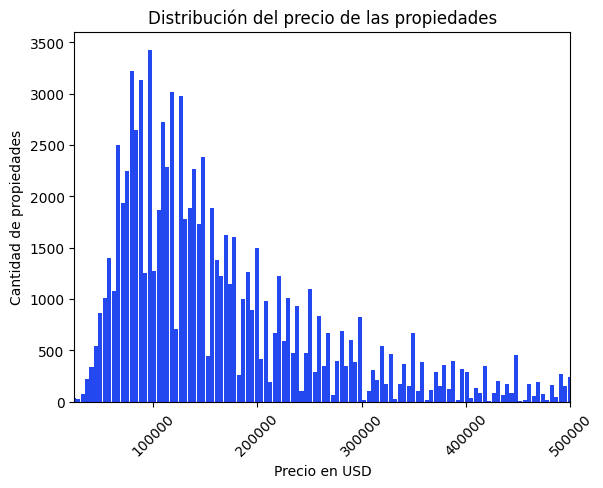

In [15]:
# plot de distribucion de property_price

plt.hist(data=ds_propiedades_filtradas,x="property_price",bins=5000, color="#2348F0",rwidth=0.9)
plt.xlim(25000,500000)
plt.xlabel("Precio en USD")
plt.ylabel("Cantidad de propiedades")
plt.title("Distribución del precio de las propiedades")
plt.xticks(rotation=45)

plt.show()

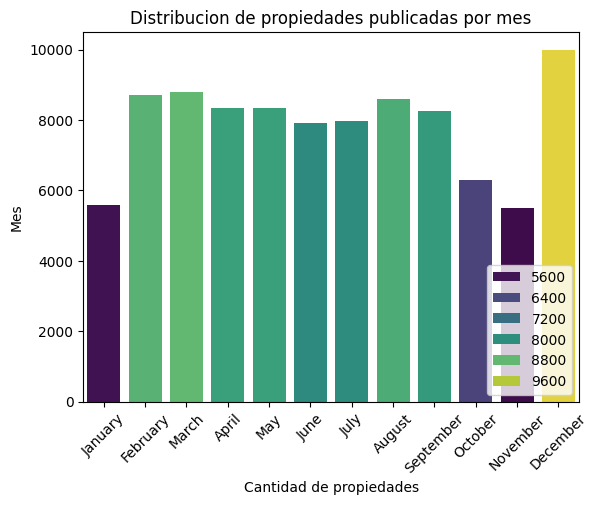

In [16]:
# bar plot distribucion de ventas por mes

ds_propiedades_filtradas["created_on"] = pd.to_datetime(ds_propiedades_filtradas["created_on"])
meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
frecuencias_mes = ds_propiedades_filtradas["created_on"].dt.month_name().value_counts().reindex(meses)
sns.barplot(x=frecuencias_mes.index, y=frecuencias_mes.values, hue=frecuencias_mes, palette='viridis')
plt.legend(loc='lower right')
plt.title('Distribucion de propiedades publicadas por mes')
plt.xlabel('Cantidad de propiedades')
plt.ylabel('Mes')
plt.xticks(rotation=45)

plt.show()

### Analisis de correlaciones existentes entre variables

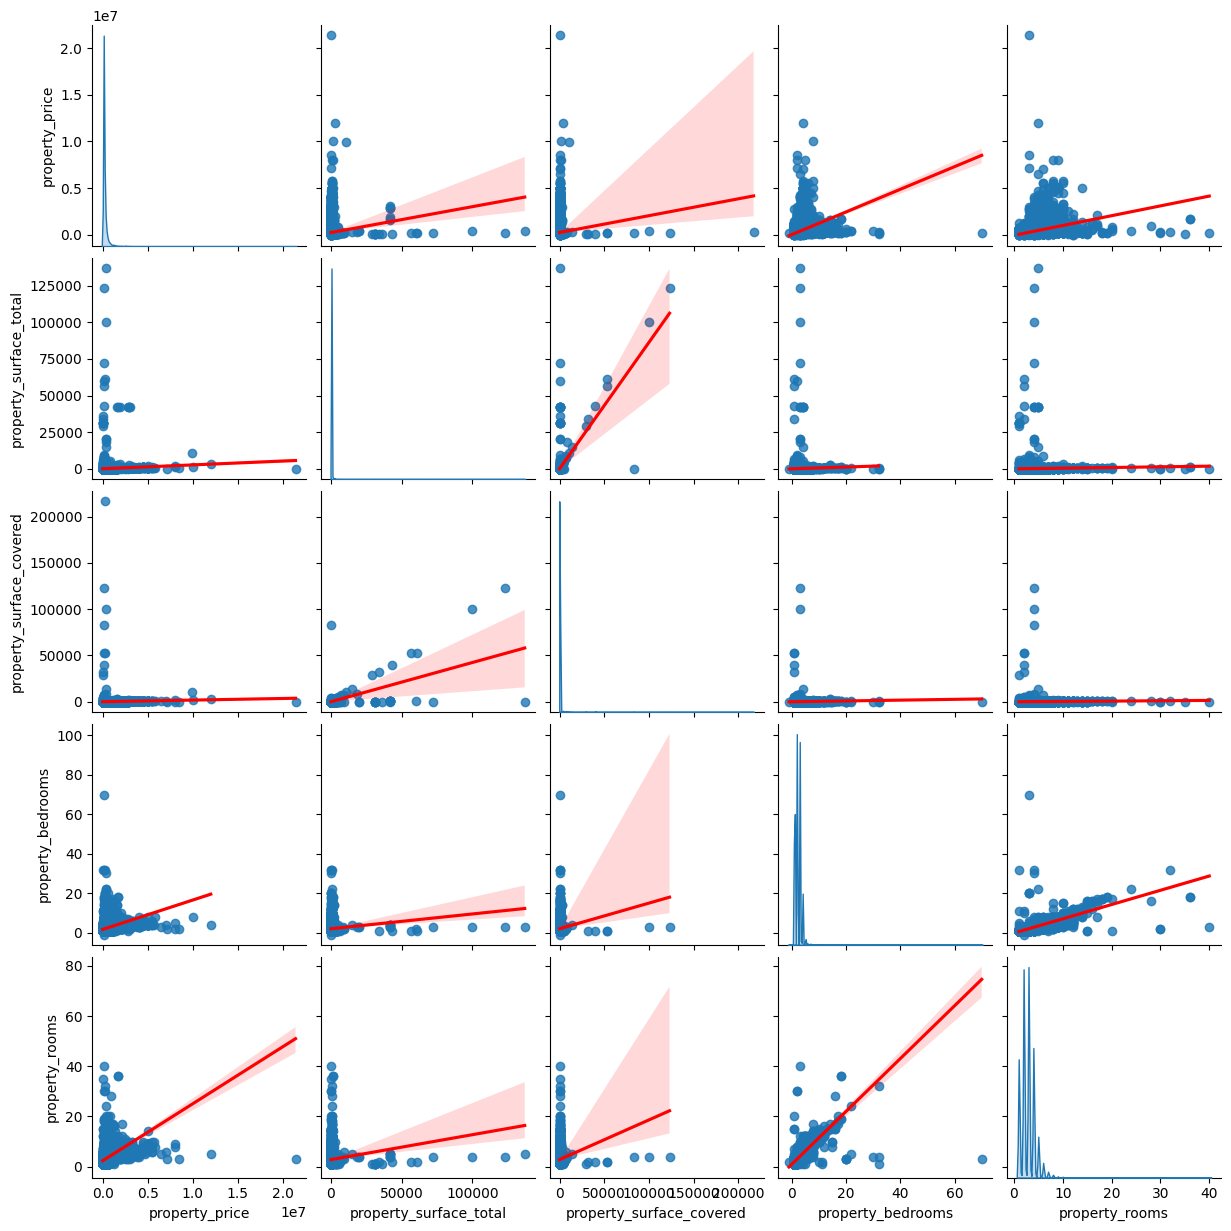

In [17]:
# pairplot con price, surface_total, surface_covered, bedrooms, rooms
sns.pairplot(ds_propiedades_filtradas[['property_price', 'property_surface_total', 'property_surface_covered', 'property_bedrooms', 'property_rooms']], diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

Observando este grafico de relaciones se pueden ver que algunas de estas variables tienen claramente una relacion y otras no tanto.

* La relacion entre la **superficie total** y **superficie cubierta** es lineal y acendente, es decir da la impresion que una dependiera de la otra, y si se piensa logicamente esto tiene sentido (si hay mas espacio se cubre mas espacio) aunque no siempre es necesariamente el caso (puede haber una casa pequeña en un terreno grande)
* La relacion entre el **precio** y la cantidad de **habitaciones** y **dormitorios**, en esta se puede notar que a mas habitaciones y/o dormitorios mas aumenta el maximo precio pero no deja de haber precios mas bajos, sin embargo, pasada una cierta cantidad (aproximadamente ~15) el precio deja de aumentar y mas bien se queda constante (entre los valores hasta ~250,000 USD)
* La relacion entre **habitaciones** y **dormitorios** tambien es lineal y acendente, lo cual puede deberse a que cuando una casa tiene muchas habitaciones esta probablemente tenga tambien muchos dormitorios.

*Extra: hay ciertos valores outliers que pueden afectar a la correlacion entre variables por ejemplo una propiedad con mas de 60 habitaciones, estos seran analizados en la seccion de valores atipicos*

Para hacer un analisis mas profundo de estos datos se analiza la *covarianza* y *correlacion* entre las variables usadas en la figura anterior:

In [18]:
# covarianza y correlacion entre property_surface_total y property_surface_covered
covariance = ds_propiedades_filtradas['property_surface_total'].cov(ds_propiedades_filtradas['property_surface_covered'])
correlation = ds_propiedades_filtradas['property_surface_total'].corr(ds_propiedades_filtradas['property_surface_covered'])
print(f'Surface Total vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_rooms
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_rooms'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_rooms'])
print(f'Price vs Rooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_bedrooms
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_bedrooms'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_bedrooms'])
print(f'Price vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_total
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_surface_total'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_surface_total'])
print(f'Price vs Surface Total\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre price y property_surface_covered
covariance = ds_propiedades_filtradas['property_price'].cov(ds_propiedades_filtradas['property_surface_covered'])
correlation = ds_propiedades_filtradas['property_price'].corr(ds_propiedades_filtradas['property_surface_covered'])
print(f'Price vs Surface Covered\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

# covarianza y correlacion entre property_rooms y property_bedrooms
covariance = ds_propiedades_filtradas['property_rooms'].cov(ds_propiedades_filtradas['property_bedrooms'])
correlation = ds_propiedades_filtradas['property_rooms'].corr(ds_propiedades_filtradas['property_bedrooms'])
print(f'Rooms vs Bedrooms\nCovariance: {covariance:.2f} & Correlation: {correlation:.2f}\n')

Surface Total vs Surface Covered
Covariance: 422567.93 & Correlation: 0.60

Price vs Rooms
Covariance: 213915.99 & Correlation: 0.49

Price vs Bedrooms
Covariance: 155132.09 & Correlation: 0.43

Price vs Surface Total
Covariance: 26682797.26 & Correlation: 0.09

Price vs Surface Covered
Covariance: 17771425.78 & Correlation: 0.06

Rooms vs Bedrooms
Covariance: 1.31 & Correlation: 0.87



Esto nos dice que en efecto lo previamente observado era el caso. Tambien ahora gracias a este analisis se ve que las relaciones mas debiles son las dadas entre el precio y las superficies totales/cubiertas.

## Visualización de los datos

In [19]:
ds_propiedades_filtradas = ds_propiedades_filtradas[ds_propiedades_filtradas['property_rooms'] < 6]
ds_propiedades_filtradas = ds_propiedades_filtradas[(ds_propiedades_filtradas['property_price'] > 20000) & (ds_propiedades_filtradas['property_price'] < 500000)]
df = ds_propiedades_filtradas.pivot_table(values='property_price', index='place_l3',columns='property_rooms')
df
#Modificamos un rango para que se vea mejor la visualizacion

property_rooms,1.0,2.0,3.0,4.0,5.0
place_l3,,,,,
Abasto,69217.483333,93577.013514,122969.072727,200176.470588,327000.000000
Agronomía,72346.294118,105211.079365,172307.462687,245677.777778,272615.736842
Almagro,76403.287779,97328.448067,140748.842600,204678.698529,271689.314607
Balvanera,66020.146667,77840.329285,118116.539541,156565.957560,206471.296296
Barracas,89309.791908,109176.360000,155940.859564,202959.759259,250813.081967
Barrio Norte,95444.509434,114794.077889,195035.655034,279883.243243,340617.829457
Belgrano,103788.116445,144599.999124,215639.008841,313862.752457,357349.828179
Boca,60988.442308,69070.353982,94057.821429,143409.803922,144500.000000
Boedo,69420.233129,90627.981675,136057.379227,203743.155280,254484.375000


Text(80.31944444444443, 0.5, 'Zonas de Capital Federal')

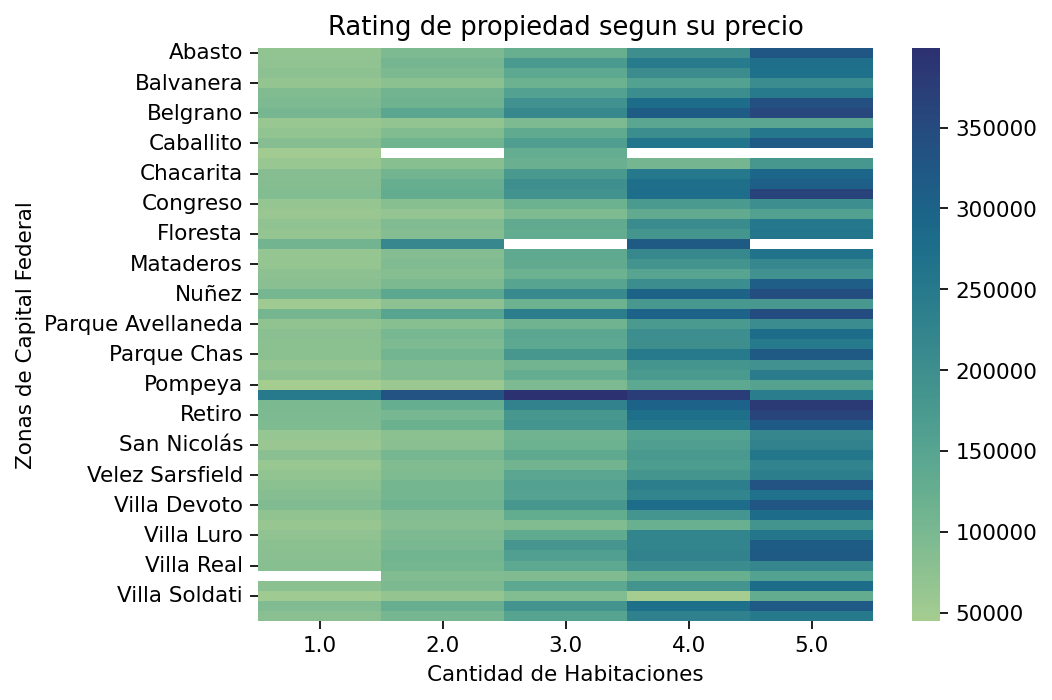

In [20]:
plt.figure(dpi=155)
plt.title("Rating de propiedad segun su precio")
sns.heatmap(df,square=False, cmap='crest')
plt.xlabel("Cantidad de Habitaciones")
plt.ylabel("Zonas de Capital Federal")
#heapmap que muestra el precio por propiedad tomando en cuenta la cantidad de habitaciones y su ubicacion

## Datos Faltantes
En esta sección se va a realizar el análsis de la presencia de datos faltantes en el set de pruebas y luego se va a aplicar en test el mismo procesamiento.

### Análisis de datos faltantes a nivel columna

Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable el porcentaje de datos faltantes con respecto al total del dataset.

#### Análisis previo

In [21]:
ds_train = prop_train
ds_test = prop_test

In [22]:
ds_train.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'latitud', 'longitud',
       'place_l2', 'place_l3', 'place_l4', 'place_l5', 'place_l6',
       'property_type', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price'],
      dtype='object')

Para iniciar, vamos a analizar la cantidad de datos faltantes por columna y su porcentaje

In [23]:
def obtener_filas(ds):
  return ds.shape[0]

def obtener_columnas(ds):
  return ds.shape[1]

In [24]:
filas = obtener_filas(ds_train)
columnas = obtener_columnas(ds_train)
print("El dataset de entrenamiento tiene {} filas y {} columnas".format(filas,columnas))

El dataset de entrenamiento tiene 75399 filas y 17 columnas


Obtengo el promedio de cada columna que contiene datos nulos

In [25]:
def obtener_promedio_nulos(ds):
  return ds.isna().sum() / obtener_filas(ds) * 100

promedio_datos_nulos = obtener_promedio_nulos(ds_train)
promedio_datos_nulos

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.964244
longitud                      3.964244
place_l2                      0.000000
place_l3                      0.437672
place_l4                     96.099418
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.099484
property_bedrooms            11.620844
property_surface_total        5.163198
property_surface_covered      3.598191
property_price                0.000000
dtype: float64

Muestro la cantidad de datos nulos por columna

In [26]:
def obtener_cantidad_nulos_ds(ds):
  return ds.isna().sum()

cant_datos_nulos = obtener_cantidad_nulos_ds(ds_train)
cant_datos_nulos

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      2989
longitud                     2989
place_l2                        0
place_l3                      330
place_l4                    72458
place_l5                    75399
place_l6                    75399
property_type                   0
property_rooms                829
property_bedrooms            8762
property_surface_total       3893
property_surface_covered     2713
property_price                  0
dtype: int64

Grafico esta relación

<ipython-input-27-f848825aef01>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')


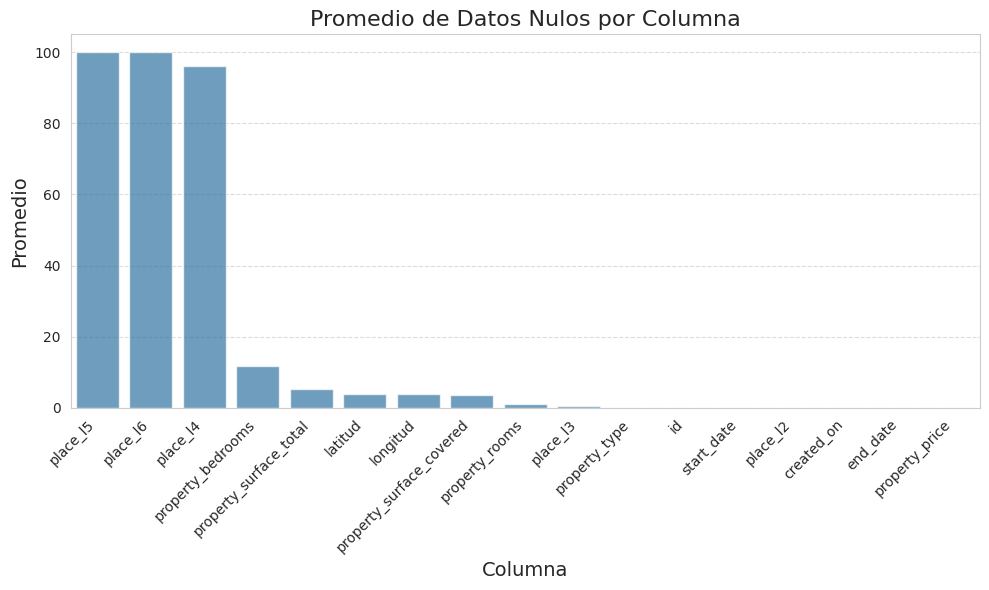

In [27]:
ds_porcentaje = promedio_datos_nulos

# Ordenar los valores en orden descendente
ds_porcentaje = ds_porcentaje.sort_values(ascending = False)

# Establecer el estilo del gráfico
sns.set_style("whitegrid")

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar el gráfico de barras
bar_plot = sns.barplot(x=ds_porcentaje.index, y=ds_porcentaje.values, alpha=0.7)

# Agregar título y etiquetas
bar_plot.set_title("Promedio de Datos Nulos por Columna", fontsize=16)
bar_plot.set_xlabel("Columna", fontsize=14)
bar_plot.set_ylabel("Promedio", fontsize=14)

# Rotar etiquetas del eje x para una mejor legibilidad
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Agregar líneas de la cuadrícula y ajustar el tamaño de la fuente
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Entonces los datos que debo analizar son:

In [28]:
def obtener_cantidad_nulos(ds):
  promedio_datos_nulos = obtener_promedio_nulos(ds)
  promedio_datos_nulos.sort_values(ascending = False,inplace=True)
  filtro = promedio_datos_nulos!=0
  return promedio_datos_nulos[filtro] if not promedio_datos_nulos[filtro].empty else 'No existen valores NaN'

obtener_cantidad_nulos(ds_train)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     96.099418
property_bedrooms            11.620844
property_surface_total        5.163198
latitud                       3.964244
longitud                      3.964244
property_surface_covered      3.598191
property_rooms                1.099484
place_l3                      0.437672
dtype: float64

In [29]:
obtener_cantidad_nulos(ds_test)

place_l5                    100.000000
place_l6                    100.000000
place_l4                     96.275862
property_bedrooms            11.803714
property_surface_total        5.045093
latitud                       3.931034
longitud                      3.931034
property_surface_covered      3.400531
property_rooms                1.140584
place_l3                      0.461538
dtype: float64

#### Elimino places (place_l6, place_l5, place_l4)

Al ver el gráfico y el análisis previo de nulos. Puedo eliminar las columnas ```place_l6```, ```place_l5``` y ```place_l4```, pues tienen en su totalidad de datos nulos. El ```place_l4``` tiene casi su totalidad de nulos.

Consideramos que las columnas ```place_l6```, ```place_l5``` son datos faltantes de tipo MCAR

In [30]:
columnas = ['place_l6','place_l5','place_l4']
ds_train.drop(columns=columnas, inplace=True)
ds_test.drop(columns=columnas, inplace=True)

In [31]:
ds_train.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
163099,s/xi1+gUfkb5CNmtGt0VXg==,2021-11-28,2021-12-31,2021-11-28,-34.566931,-58.462353,Capital Federal,Belgrano,Departamento,3.0,2.0,75.0,NaN,175000.0
194657,m5LwwT9lblHRC6gQ4hUtLA==,2021-08-21,2022-02-09,2021-08-21,-34.590769,-58.468700,Capital Federal,Villa Ortuzar,PH,4.0,3.0,214.0,128.0,310000.0
370716,tLFTDJdArx8jXfr56Xp36A==,2021-04-24,2021-08-23,2021-04-24,-34.620609,-58.469621,Capital Federal,Flores,PH,4.0,3.0,162.0,120.0,170000.0
447149,iXnJelKuXCWWtKhorAOo1g==,2021-05-22,2021-06-05,2021-05-22,-34.560864,-58.480387,Capital Federal,Coghlan,Departamento,1.0,NaN,43.0,37.0,99000.0
430837,t9EE5qtZjeI9qOYrXQzKUg==,2021-12-16,2022-02-09,2021-12-16,-34.600820,-58.520193,Capital Federal,Villa Devoto,Departamento,3.0,2.0,74.0,60.0,185000.0


In [32]:
ds_test.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
422132,ZRuguDNjpiXq/WeDO9v78w==,2021-07-07,2022-08-25,2021-07-07,-34.567537,-58.436881,Capital Federal,Palermo,Departamento,3.0,2.0,111.0,94.0,315000.0
233867,nSVkp+QQwpP3Fy4LEsoeVA==,2021-03-20,2021-03-28,2021-03-20,-34.598702,-58.496876,Capital Federal,Villa del Parque,Departamento,2.0,1.0,41.0,39.0,93000.0
150593,KlySzdJXvCWkJPmxZaIi3g==,2021-03-24,2021-06-21,2021-03-24,-34.639597,-58.369096,Capital Federal,Barracas,Departamento,2.0,1.0,118.0,111.0,179900.0
218610,U1R5uhBowY89/fIE3Xzqow==,2021-11-30,2021-12-09,2021-11-30,-34.595960,-58.396517,Capital Federal,Barrio Norte,Departamento,2.0,1.0,40.0,40.0,95000.0
385819,nYdY7OL8Jyp+I6ki5D8tUg==,2021-02-10,2021-05-31,2021-02-10,-34.607370,-58.441696,Capital Federal,Villa Crespo,Departamento,2.0,1.0,45.0,45.0,78000.0


In [33]:
nulos_preimputacion = obtener_cantidad_nulos(ds_train)

In [34]:
obtener_cantidad_nulos(ds_test)

property_bedrooms           11.803714
property_surface_total       5.045093
latitud                      3.931034
longitud                     3.931034
property_surface_covered     3.400531
property_rooms               1.140584
place_l3                     0.461538
dtype: float64

#### Generar funciones para análisis

In [35]:
# establezco si son o no nulos
def generar_ds_nulo(columnas):
  return ds_train[columnas].isna()

def filtrar_nulo(columna,ds):
  return ds[columna]==True

def filtrar_no_nulo(columna,ds):
  return ds[columna]==False

def aplicar_filtro(ds,filtro,columna,nulidad):
  ds.loc[filtro,columna] = nulidad
  return ds

In [36]:
def contar_ds(ds,columna):
  return ds[columna].value_counts()

def imprimir_cantidades(nulos,no_nulos,columna):
  print("Cantidad de datos NULOS en {}: {}".format(columna,nulos))
  print("Cantidad de datos NO NULOS en {}: {}".format(columna,no_nulos))

In [37]:
def generar_grafico(ds, columna):
    titulo = "Gráfico de barras: Cantidad de nulos en la variable " + columna
    ds[columna].value_counts().plot.bar(alpha=0.5, title=titulo, xlabel="tipo de dato", ylabel="cantidad de filas", fontsize=10)

#### Latitud y longitud
Vamos a anlizar los nulos de estas dos variables

In [38]:
latatitud_longitud = generar_ds_nulo(['latitud','longitud'])
# filtros latitud
v_filtro_latitud = filtrar_nulo('latitud',latatitud_longitud)
f_filtro_latitud = filtrar_no_nulo('latitud',latatitud_longitud)
# filtros longitud
v_filtro_longitud = filtrar_nulo('longitud',latatitud_longitud)
f_filtro_longitud = filtrar_no_nulo('longitud',latatitud_longitud)
# aplico los filtros
latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_latitud,'latitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_latitud,'latitud','no nulo')

latatitud_longitud = aplicar_filtro(latatitud_longitud,v_filtro_longitud,'longitud','nulo')
latatitud_longitud = aplicar_filtro(latatitud_longitud,f_filtro_longitud,'longitud','no nulo')

latatitud_longitud.head()



,latitud,longitud
163099,no nulo,no nulo
194657,no nulo,no nulo
370716,no nulo,no nulo
447149,no nulo,no nulo
430837,no nulo,no nulo


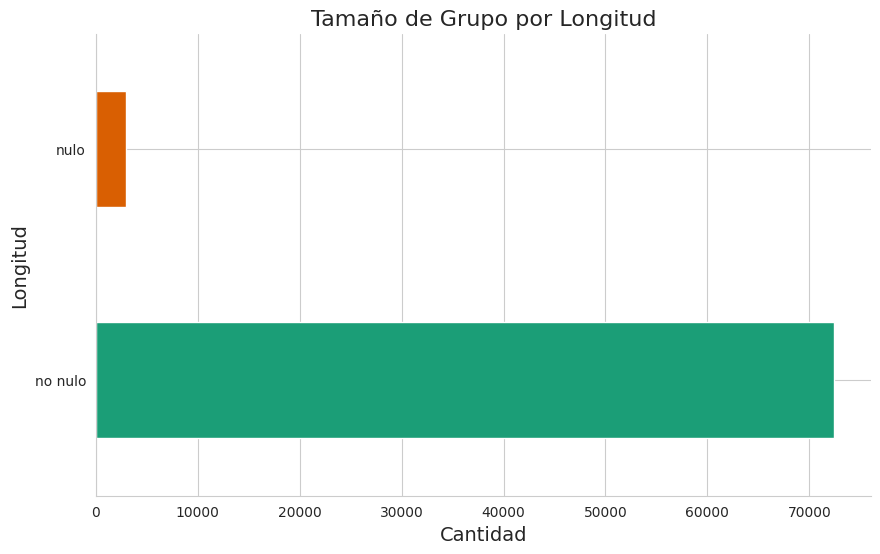

In [39]:
# @title Longitud
# Suponiendo que 'latatitud_longitud' es tu DataFrame
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Agrupar por 'longitud' y obtener el tamaño de cada grupo, luego trazar el gráfico de barras horizontales
latatitud_longitud.groupby('longitud').size().plot(kind='barh', color=sns.color_palette('Dark2'))

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Configurar el tamaño de la letra del título y las etiquetas
plt.title('Tamaño de Grupo por Longitud', fontsize=16)
plt.xlabel('Cantidad', fontsize=14)
plt.ylabel('Longitud', fontsize=14)

# Mostrar el gráfico
plt.show()


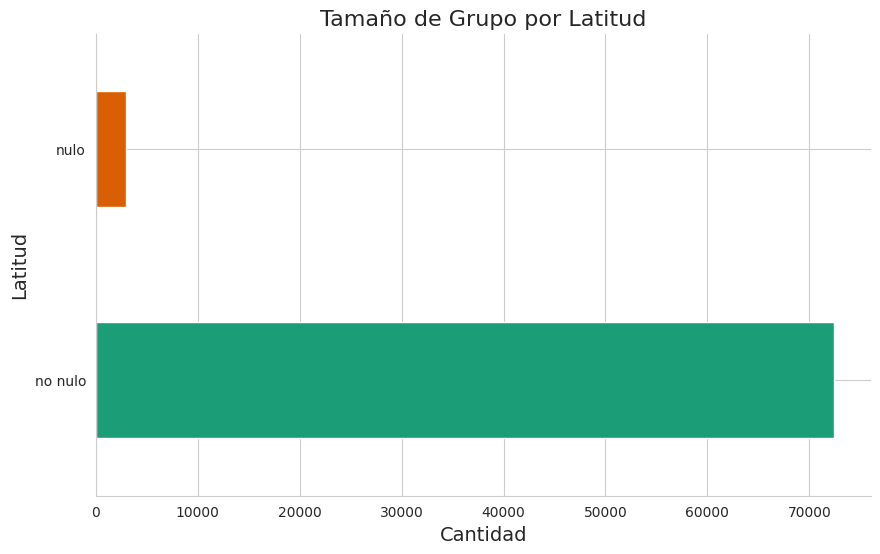

In [40]:
# @title Latitud
# Suponiendo que 'latatitud_longitud' es tu DataFrame
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Agrupar por 'latitud' y obtener el tamaño de cada grupo, luego trazar el gráfico de barras horizontales
latatitud_longitud.groupby('latitud').size().plot(kind='barh', color=sns.color_palette('Dark2'))

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Configurar el tamaño de la letra del título y las etiquetas
plt.title('Tamaño de Grupo por Latitud', fontsize=16)
plt.xlabel('Cantidad', fontsize=14)
plt.ylabel('Latitud', fontsize=14)

# Mostrar el gráfico
plt.show()

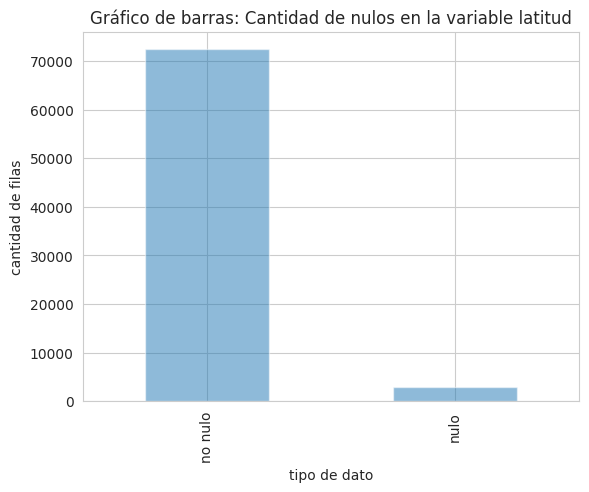

In [41]:
generar_grafico(latatitud_longitud,'latitud')

In [42]:
cant_nulos_longitud,cant_no_nulos_longitud = contar_ds(latatitud_longitud,'longitud')
imprimir_cantidades(cant_nulos_longitud,cant_no_nulos_longitud,'longitud')

Cantidad de datos NULOS en longitud: 72410
Cantidad de datos NO NULOS en longitud: 2989


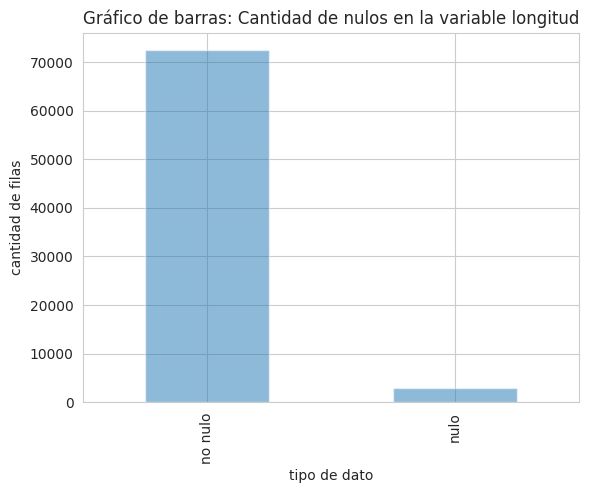

In [43]:
generar_grafico(latatitud_longitud,'longitud')

#### Superficie total y Superficie cubierta (property_surface_total, property_surface_covered)

In [44]:
# establezco si son o no nulos
sup_total_cubierta = generar_ds_nulo(['property_surface_total','property_surface_covered'])
# creo filtro si son o no nulos
v_filtro_total =  filtrar_nulo('property_surface_total',sup_total_cubierta)
f_filtro_total =  filtrar_no_nulo('property_surface_total',sup_total_cubierta)

v_filtro_cubierto =  filtrar_nulo('property_surface_covered',sup_total_cubierta)
f_filtro_cubierto =  filtrar_no_nulo('property_surface_covered',sup_total_cubierta)
# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_total,'property_surface_total','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_total,'property_surface_total','no nulo')

# establezco los nulos y no nulos
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,v_filtro_cubierto,'property_surface_covered','nulo')
sup_total_cubierta = aplicar_filtro(sup_total_cubierta,f_filtro_cubierto,'property_surface_covered','no nulo')

sup_total_cubierta.head()

,property_surface_total,property_surface_covered
163099,no nulo,nulo
194657,no nulo,no nulo
370716,no nulo,no nulo
447149,no nulo,no nulo
430837,no nulo,no nulo


In [45]:
cant_nulos_total, cant_no_nulos_total = contar_ds(sup_total_cubierta,'property_surface_total')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_surface_total')

Cantidad de datos NULOS en property_surface_total: 71506
Cantidad de datos NO NULOS en property_surface_total: 3893


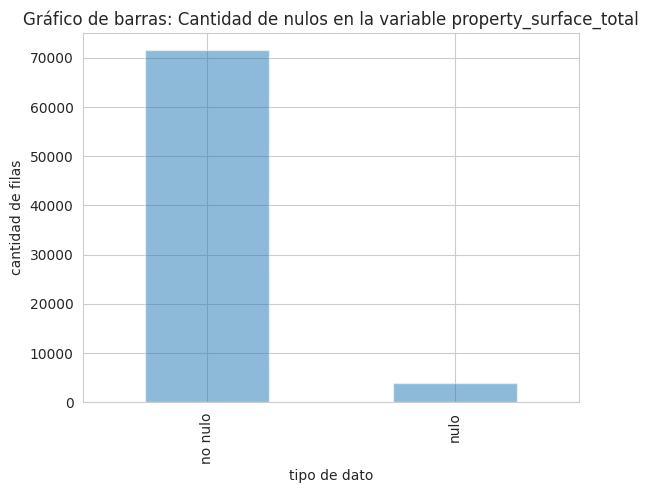

In [46]:
generar_grafico(sup_total_cubierta,'property_surface_total')

In [47]:
cant_nulos_total, cant_no_nulos_total = contar_ds(sup_total_cubierta,'property_surface_covered')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_surface_covered')

Cantidad de datos NULOS en property_surface_covered: 72686
Cantidad de datos NO NULOS en property_surface_covered: 2713


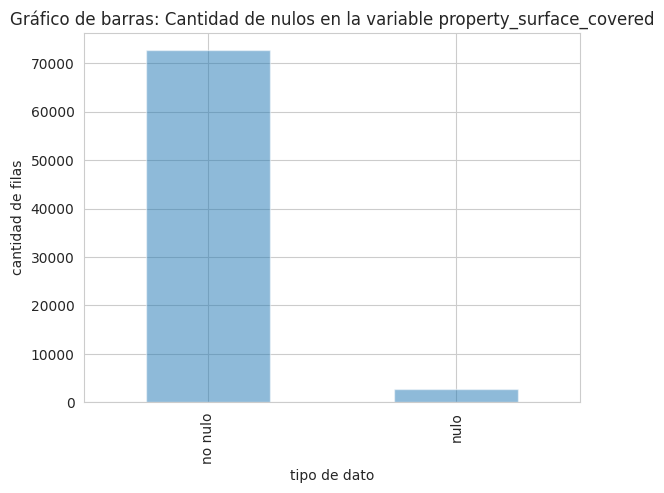

In [48]:
generar_grafico(sup_total_cubierta,'property_surface_covered')

#### Habitaciones y dormitorios (property_rooms, property_bedrooms)

In [49]:
# establezco si son o no nulos
habitaciones_dormis = generar_ds_nulo(['property_rooms','property_bedrooms'])
# creo filtro si son o no nulos
v_filtro_hab = filtrar_nulo('property_rooms',habitaciones_dormis)
f_filtro_hab =  filtrar_no_nulo('property_rooms',habitaciones_dormis)

v_filtro_dormis =  filtrar_nulo('property_bedrooms',habitaciones_dormis)
f_filtro_dormis =  filtrar_no_nulo('property_bedrooms',habitaciones_dormis)

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_hab,'property_rooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_hab,'property_rooms','no nulo')

# establezco los nulos y no nulos
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,v_filtro_dormis,'property_bedrooms','nulo')
habitaciones_dormis = aplicar_filtro(habitaciones_dormis,f_filtro_dormis,'property_bedrooms','no nulo')

habitaciones_dormis.head()

,property_rooms,property_bedrooms
163099,no nulo,no nulo
194657,no nulo,no nulo
370716,no nulo,no nulo
447149,no nulo,nulo
430837,no nulo,no nulo


In [50]:
cant_nulos_total, cant_no_nulos_total = contar_ds(habitaciones_dormis,'property_rooms')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_rooms')

Cantidad de datos NULOS en property_rooms: 74570
Cantidad de datos NO NULOS en property_rooms: 829


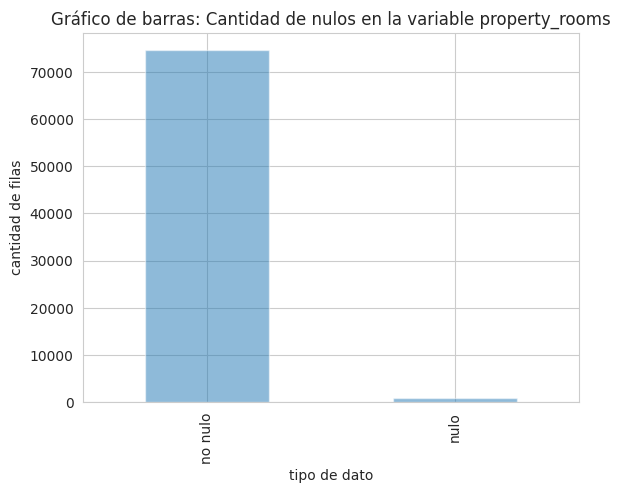

In [51]:
generar_grafico(habitaciones_dormis,'property_rooms')

In [52]:
cant_nulos_total, cant_no_nulos_total = contar_ds(habitaciones_dormis,'property_bedrooms')
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'property_bedrooms')

Cantidad de datos NULOS en property_bedrooms: 66637
Cantidad de datos NO NULOS en property_bedrooms: 8762


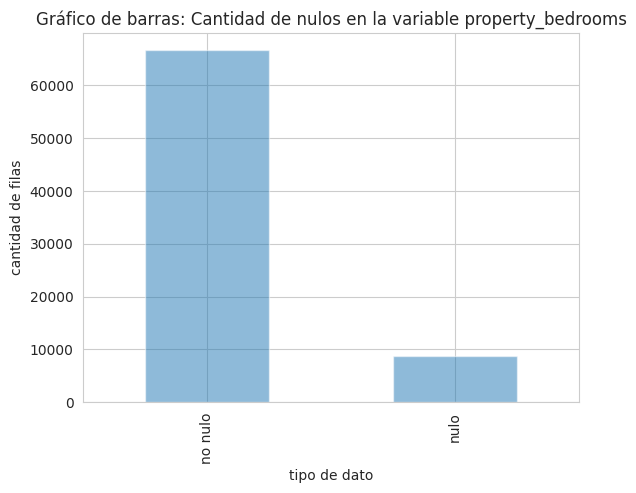

In [53]:
generar_grafico(habitaciones_dormis,'property_bedrooms')

#### Barrio (place_l3)

In [54]:
# establezco si son o no nulos
barrio = generar_ds_nulo('place_l3')
# creo filtro si son o no nulos
v_filtro_barrio =  barrio == True
f_filtro_barrio =  barrio == False
# establezco los nulos y no nulos
barrio.loc[v_filtro_barrio] = 'nulo'
barrio.loc[f_filtro_barrio] = 'no nulo'

barrio.head()

163099    no nulo
194657    no nulo
370716    no nulo
447149    no nulo
430837    no nulo
Name: place_l3, dtype: object

In [55]:
cant_nulos_barrio,cant_no_nulos_barrio = barrio.value_counts()
imprimir_cantidades(cant_nulos_total,cant_no_nulos_total,'place_l3')

Cantidad de datos NULOS en place_l3: 66637
Cantidad de datos NO NULOS en place_l3: 8762


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable place_l3'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

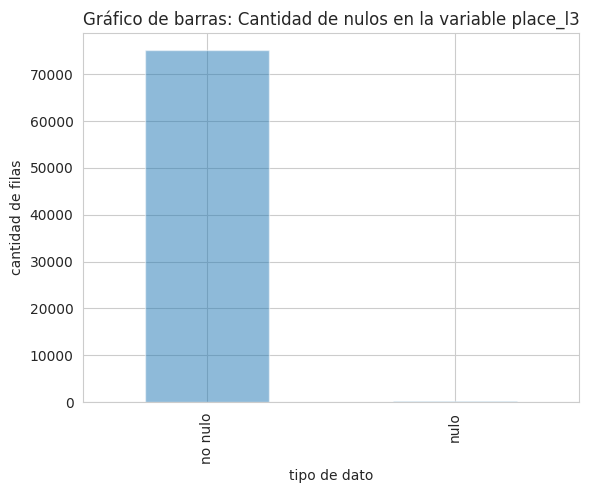

In [56]:
barrio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable place_l3", xlabel="tipo de dato" , ylabel="cantidad de filas")

#### Precio

In [57]:
precio = generar_ds_nulo('property_price')
# creo filtro si son o no nulos
v_filtro_precio =  precio == True
f_filtro_precio =  precio == False
# establezco los nulos y no nulos
precio.loc[v_filtro_precio] = 'nulo'
precio.loc[f_filtro_precio] = 'no nulo'

precio.head()

163099    no nulo
194657    no nulo
370716    no nulo
447149    no nulo
430837    no nulo
Name: property_price, dtype: object

In [58]:
print("Cantidad de datos NO NULOS en property_price: {}".format(precio.value_counts()))

Cantidad de datos NO NULOS en property_price: property_price
no nulo    75399
Name: count, dtype: int64


<Axes: title={'center': 'Gráfico de barras: Cantidad de nulos en la variable property_price'}, xlabel='tipo de dato', ylabel='cantidad de filas'>

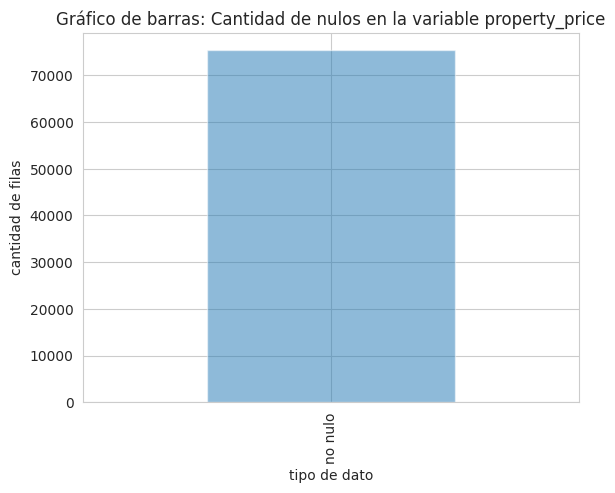

In [59]:
precio.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de nulos en la variable property_price", xlabel="tipo de dato" , ylabel="cantidad de filas")

### Análisis de datos faltantes a nivel fila

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos
faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de
faltantes por fila en el dataset.


In [60]:
# Calcular la cantidad de filas nulas
cantidad_filas_nulas = ds_train.isna().sum(axis=1)
filtro = cantidad_filas_nulas > 0
cantidad_filas_nulas = cantidad_filas_nulas[filtro]
print("La cantidad de filas que tienen al menos un dato nulo es: ",len(cantidad_filas_nulas))

La cantidad de filas que tienen al menos un dato nulo es:  17128


<Axes: title={'center': 'Gráfico de barras: Cantidad de filas nulas en ds_train'}, xlabel='cantidad de nulos', ylabel='cantidad de filas'>

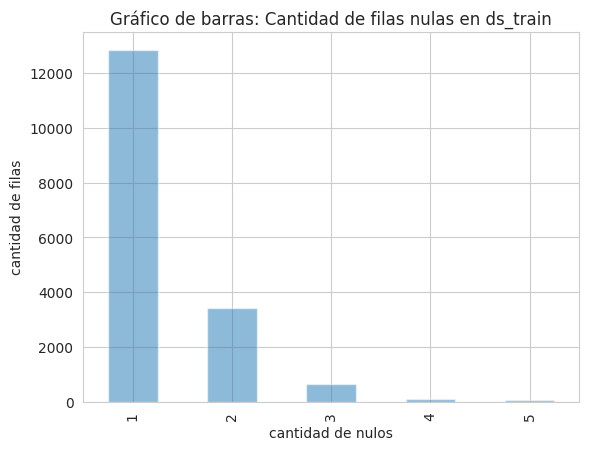

In [61]:
cantidad_filas_nulas.value_counts().plot.bar(alpha=0.5,title="Gráfico de barras: Cantidad de filas nulas en ds_train", xlabel="cantidad de nulos" , ylabel="cantidad de filas")

### Revisión de datos faltantes o mal ingresados

Revisar los datos faltantes o mal ingresados y tomar una decisión sobre estos: reemplazo de
valores, eliminación de registros incompletos, etc.

Recordemos los datos nulos que tenemos en ds_train

In [62]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.620844
property_surface_total       5.163198
latitud                      3.964244
longitud                     3.964244
property_surface_covered     3.598191
property_rooms               1.099484
place_l3                     0.437672
dtype: float64

Veremos unas de las estrategias para para trabajar con datos faltantes. Procederemos a imputar datos

#### Imputación Cold Deck
Vamos a trabajar con los datos ```latitud``` y ```longitud``` para completar la variable ```place_l3```.
Para ello vamos a utilizar el csv ```barrios.csv``` provisto por [GCBA](https://data.buenosaires.gob.ar/dataset/barrios/resource/juqdkmgo-191-resource) que nos da la localización y límites geográficos de los barrios de la Ciudad.

Antes de imputar vamos a hacer una copia para analizar la imputación en el siguiente punto.

In [63]:
ds_pre_imputacion = ds_train.copy()

Para ello vamos a usar Geopandas correspondiente a la documentación wkt

In [64]:
ds_barrios = pd.read_csv(barrios_file, header=0,sep=';')
def completar_barrios(ds):
  for index, propiedad in ds.iterrows():
    if isinstance(propiedad["place_l3"], str):
      continue

    for index,barrio in ds_barrios.iterrows():
      barrio_aux = barrio['BARRIO']
      if barrio_aux == '' or barrio_aux is None:
        continue
      coordenada = Point(propiedad['longitud'],propiedad['latitud'])
      # uso wkt Para deserializar una cadena y obtener un nuevo objeto geométrico del tipo apropiado
      # uso covers para ver si está cubierta la coordenada de ds_barrios por lo que tiene mi ds
      if wkt.loads(barrio['WKT']).covers(coordenada):
        ds.loc[index,'place_l3'] = barrio_aux

  return

completar_barrios(ds_train)
completar_barrios(ds_test)

Visualizamos el dataset para ver si podemos ver algún nulo rápido.

In [65]:
# Ordenar el DataFrame por 'place_l3'
ds_train_sorted = ds_train.sort_values(by='place_l3')

# Extraer la columna 'place_l3'
place_l3_column = ds_train_sorted['place_l3']

# Elimino la columna 'place_l3' del DataFrame
ds_train_sorted.drop(columns=['place_l3'], inplace=True)

# Inserto la columna 'place_l3' en la primera posición
ds_train_sorted.insert(0, 'place_l3', place_l3_column)

# Ahora ds_train_sorted tiene 'place_l3' como la primera columna
# para visualizarlo mejor
ds_train_sorted

,place_l3,id,start_date,end_date,created_on,latitud,longitud,place_l2,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
27,AGRONOMIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ALMAGRO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124253,Abasto,P62b3IKueqvB2qUsP/BsOg==,2021-11-26,2021-12-15,2021-11-26,-34.604245,-58.413048,Capital Federal,Departamento,4.0,3.0,110.0,100.0,335000.0
370698,Abasto,ske7DYXyr6XWsGBQvlssCQ==,2021-04-24,2021-05-02,2021-04-24,-34.600384,-58.410922,Capital Federal,Departamento,1.0,1.0,31.0,25.0,47000.0
409020,Abasto,jkJOwKM968cRXnIJl9ueMg==,2021-03-19,2021-04-09,2021-03-19,-34.604617,-58.407126,Capital Federal,Departamento,2.0,1.0,37.0,37.0,80000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93735,NaN,vcC8CoaxE+rvd1EbVR8qMA==,2021-09-24,9999-12-31,2021-09-24,-34.584680,-58.421772,Capital Federal,Departamento,4.0,NaN,71.0,64.0,170000.0
296346,NaN,i+lEVAlk2+Dsmc63c2DYUw==,2021-04-26,2021-06-05,2021-04-26,NaN,NaN,Capital Federal,PH,3.0,2.0,75.0,75.0,85000.0
163803,NaN,nc0ntMQxgHruhBOAOk3AIg==,2021-06-07,2022-01-30,2021-06-07,NaN,NaN,Capital Federal,Departamento,1.0,NaN,29.0,29.0,63500.0
67274,NaN,FqsOIr7Sr9gweeHnkzWDBg==,2021-08-02,9999-12-31,2021-08-02,-34.608098,-58.420524,Capital Federal,Departamento,5.0,NaN,94.0,94.0,199000.0


Vemos que hay datos NaN en el barrio

In [66]:
ds_train['place_l3'].isna().value_counts()

place_l3
False    75084
True       330
Name: count, dtype: int64

Estos datos en NaN pueden ser datos mal ingresados. Se ingresó mal la coordenada de la propiedad y se la clasificó como Capital Federal. Lo mismo puede suceder de que no tengan latitud ni longitud. Procedo a eliminar dichos datos

In [67]:
columnas_a_eliminar = ['latitud','longitud','place_l3']
ds_train = ds_train.dropna(subset=columnas_a_eliminar)
ds_test =  ds_test.dropna(subset=columnas_a_eliminar)

Verifico mis datos_nulos en mi dataset

In [68]:
obtener_cantidad_nulos(ds_train)

property_bedrooms           11.507145
property_surface_total       5.065359
property_surface_covered     3.560153
property_rooms               0.956852
dtype: float64

#### Análisis de property's
Ahora vamos a seguir con el análisis de las siguientes variables:
*     property_bedrooms
*     property_rooms
*     property_surface_total
*     property_surface_covered

Podemos identificar que estas variables son tipos de datos faltantes MAR.

##### Análisis de ceros

Para empezar verifico si alguno de estos datos es negativo. Pues valores negativos para alguno de estos atributos no tiene sentido.

In [69]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

,Menor o igual que 0 ?
property_bedrooms,True
property_rooms,False
property_surface_total,False
property_surface_covered,False


Vemos que existen valores menores o iguales que 0 en el atributo ```property_bedrooms```. Procedo a ver cuantos registros cumplen con esta condición.

In [70]:
filtro = ds_propiedades_filtradas['property_bedrooms'] < 1
ds_propiedades_filtradas[filtro]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,-1.0,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Como hay un registro, procedo a asignarlo nulo.

In [71]:
ds_train.loc[ds_train['property_bedrooms'] < 1,'property_bedrooms'] = np.nan

Verifico si hay valores menores o iguales que cero.

In [72]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_train[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

,Menor o igual que 0 ?
property_bedrooms,False
property_rooms,False
property_surface_total,False
property_surface_covered,False


Realizo el mismo análisis con ds_test

In [73]:
columnas_con_numeros = ['property_bedrooms','property_rooms','property_surface_total','property_surface_covered']
(ds_test[columnas_con_numeros] <= 0).any().to_frame("Menor o igual que 0 ?")

,Menor o igual que 0 ?
property_bedrooms,False
property_rooms,False
property_surface_total,False
property_surface_covered,False


##### Análisis de duplicados

Verifico si hay datos duplicados en estas columnas

In [74]:
ds_train[ds_train.duplicated(keep=False)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price


In [75]:
ds_test[ds_test.duplicated(keep=False)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price


Procedo a eliminar filas duplicadas

In [76]:
size_antes = len(ds_train)
ds_train_filtrado = ds_train.drop_duplicates()
size_despues = len(ds_train_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_train")

Se eliminaron: 0 filas duplicadas de ds_train


In [77]:
ds_train_filtrado.reset_index(drop=True, inplace=True)

In [78]:
size_antes = len(ds_test)
ds_test_filtrado = ds_test.drop_duplicates()
size_despues = len(ds_test_filtrado)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas de ds_test")

Se eliminaron: 0 filas duplicadas de ds_test


In [79]:
ds_test_filtrado.reset_index(drop=True, inplace=True)

##### Completo las columnas de forma multivariada

Como las variables faltantes son datos de tipo MAR (Missing At Random), elijo el proceso de imputación de datos MICE (Multivariate Imputation by Chained Equations)

In [80]:
# la variable columnas_con_numeros tiene las columnas a analizar
lr = LinearRegression()
imp = IterativeImputer(
    estimator=lr,
    missing_values = np.nan,
    max_iter = 20,
    verbose = 0,
    random_state = 0,
    min_value = 1
)


def rellenar_variables(ds,columnas):
  df_eliminar_nans_op3_completo = ds[columnas].copy()
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)

rellenar_variables(ds_train,columnas_con_numeros)
rellenar_variables(ds_test,columnas_con_numeros)


<ipython-input-80-f0def5aab7fb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)
<ipython-input-80-f0def5aab7fb>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[columnas] = imp.fit_transform(df_eliminar_nans_op3_completo)


In [81]:
obtener_promedio_nulos(ds_train)

id                          0.0
start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l2                    0.0
place_l3                    0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
dtype: float64

In [82]:
obtener_cantidad_nulos(ds_train)

'No existen valores NaN'

### Comparación de distribuciones
En caso de realizar imputaciones comparar las distribuciones de cada atributo reparado con
la distribución anterior a la imputación de los datos faltantes.

Para ello veamos nuestro ```ds_pre_imputacion```

In [83]:
ds_pre_imputacion.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
163099,s/xi1+gUfkb5CNmtGt0VXg==,2021-11-28,2021-12-31,2021-11-28,-34.566931,-58.462353,Capital Federal,Belgrano,Departamento,3.0,2.0,75.0,NaN,175000.0
194657,m5LwwT9lblHRC6gQ4hUtLA==,2021-08-21,2022-02-09,2021-08-21,-34.590769,-58.468700,Capital Federal,Villa Ortuzar,PH,4.0,3.0,214.0,128.0,310000.0
370716,tLFTDJdArx8jXfr56Xp36A==,2021-04-24,2021-08-23,2021-04-24,-34.620609,-58.469621,Capital Federal,Flores,PH,4.0,3.0,162.0,120.0,170000.0
447149,iXnJelKuXCWWtKhorAOo1g==,2021-05-22,2021-06-05,2021-05-22,-34.560864,-58.480387,Capital Federal,Coghlan,Departamento,1.0,NaN,43.0,37.0,99000.0
430837,t9EE5qtZjeI9qOYrXQzKUg==,2021-12-16,2022-02-09,2021-12-16,-34.600820,-58.520193,Capital Federal,Villa Devoto,Departamento,3.0,2.0,74.0,60.0,185000.0


Recordemos que datos imputamos

In [84]:
nulos_preimputacion

property_bedrooms           11.620844
property_surface_total       5.163198
latitud                      3.964244
longitud                     3.964244
property_surface_covered     3.598191
property_rooms               1.099484
place_l3                     0.437672
dtype: float64

In [85]:
nulos_preimputacion.index.tolist()

['property_bedrooms',
 'property_surface_total',
 'latitud',
 'longitud',
 'property_surface_covered',
 'property_rooms',
 'place_l3']

Para ver la distribuciones de las variables imputadas vamos a utilizar un gráfico de distribución continua BoxPlot. El cual nos va a ayudar a visualizar la distribución de los datos y la asimetría de los mismos mediante la visualización de cuartiles y promedios de los datos.

#### Funciones de distribución

In [86]:
def generar_distribucion(variable):
  # Configuración de estilo y colores
  sns.set(style="whitegrid")
  sns.set_palette("pastel")

  # Creo la cuadrícula de subgráficos con una fila y dos columnas
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0], width=0.5)
  axes[0].set_title("Boxplot {} pre-imputación".format(variable), fontsize=14)
  axes[0].set_ylabel("Valor", fontsize=12)
  axes[0].set_xlabel("", fontsize=12)

  # Genero boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1], width=0.5)
  axes[1].set_title("Boxplot {} post-imputación".format(variable), fontsize=14)
  axes[1].set_ylabel("Valor", fontsize=12)
  axes[1].set_xlabel("", fontsize=12)

  # Ajusto el diseño
  plt.tight_layout()

  plt.show()

  return

In [87]:
def generar_distribucion_zoom(variable):
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Genero boxplot para ds_pre_imputacion en el primer subgráfico
  sns.boxplot(y=variable, data=ds_pre_imputacion, ax=axes[0])
  axes[0].set_title("Boxplot {} pre-imputacion".format(variable))
  axes[0].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Genero boxplot para ds_train en el segundo subgráfico
  sns.boxplot(y=variable, data=ds_train, ax=axes[1])
  axes[1].set_title("Boxplot {} post-imputacion".format(variable))
  axes[1].set_ylim(0, 10)  # Ajustar el rango del eje y

  # Ajustar el diseño
  plt.tight_layout()

  plt.show()
  return

In [88]:
def obtener_cantidad_variables(ds,columna):
  analisis = ds[columna].value_counts().reset_index()
  analisis.columns = [columna, 'cantidad']
  return analisis

In [89]:
def comparar_imputacion(pre, post, columna):
    for i in range(len(pre)):
        registros_imputados = post['cantidad'][i] - pre['cantidad'][i]
        registros_imputados = abs(registros_imputados)  # Tomar el valor absoluto
        print("{} registros se imputaron con el valor de {} {}".format(registros_imputados, pre[columna][i], columna))
    return

#### Comparación property_bedrooms

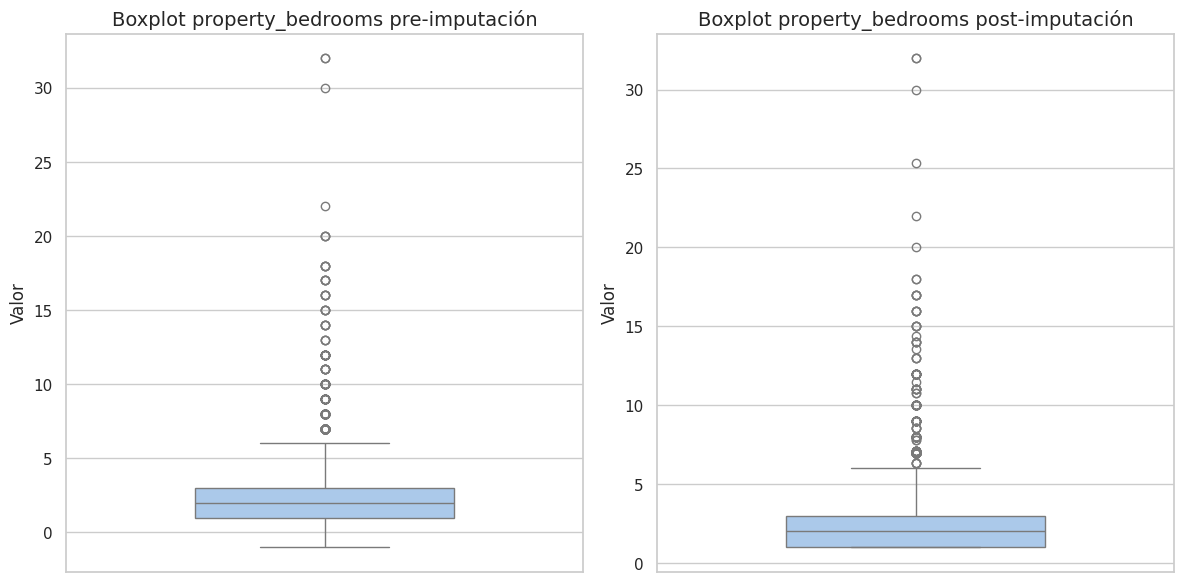

In [90]:
generar_distribucion("property_bedrooms")

Un poco de zoom

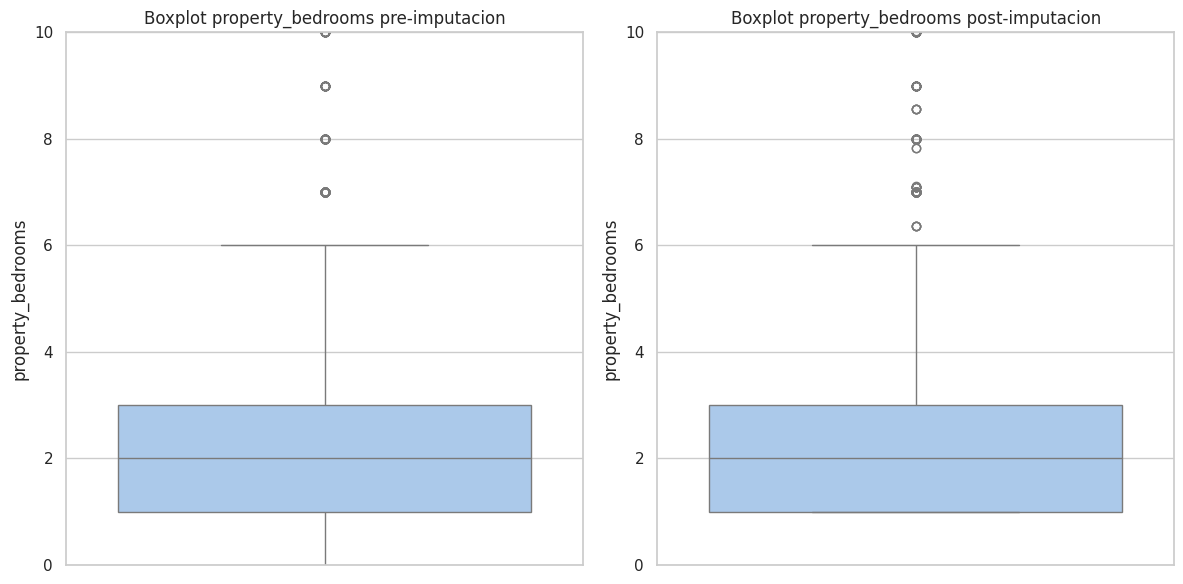

In [91]:
generar_distribucion_zoom("property_bedrooms")

La comparación de los boxplots revela una gran coherencia en la distribución de la variable entre los conjuntos de datos antes y después de la imputación. Aunque se observa una discrepancia leve entre los valores de aproximadamente 20 y 30, esta diferencia es mínima en comparación con la totalidad de los datos. Esto sugiere que las imputaciones se realizaron de manera consistente y dentro de los límites razonables de la variable, sin introducir valores atípicos o extremos.

Vamos a analizar cada property_bedrooms

In [92]:
pre_bedrooms = obtener_cantidad_variables(ds_pre_imputacion,'property_bedrooms')
pre_bedrooms.head()

,property_bedrooms,cantidad
0,1.0,25610
1,2.0,21909
2,3.0,14107
3,4.0,3871
4,5.0,729


In [93]:
post_bedrooms = obtener_cantidad_variables(ds_train,'property_bedrooms')
post_bedrooms.head()

,property_bedrooms,cantidad
0,1.0,31962
1,2.0,21100
2,3.0,13442
3,4.0,3662
4,5.0,675


Con esto podemos ver la cantidad de imputaciones que se hicieron gracias al método MICE.

In [94]:
comparar_imputacion(pre_bedrooms,post_bedrooms,'property_bedrooms')

6352 registros se imputaron con el valor de 1.0 property_bedrooms
809 registros se imputaron con el valor de 2.0 property_bedrooms
665 registros se imputaron con el valor de 3.0 property_bedrooms
209 registros se imputaron con el valor de 4.0 property_bedrooms
54 registros se imputaron con el valor de 5.0 property_bedrooms
14 registros se imputaron con el valor de 6.0 property_bedrooms
3 registros se imputaron con el valor de 7.0 property_bedrooms
1 registros se imputaron con el valor de 8.0 property_bedrooms
0 registros se imputaron con el valor de 10.0 property_bedrooms
1 registros se imputaron con el valor de 9.0 property_bedrooms
0 registros se imputaron con el valor de 12.0 property_bedrooms
4 registros se imputaron con el valor de 11.0 property_bedrooms
5 registros se imputaron con el valor de 15.0 property_bedrooms
4 registros se imputaron con el valor de 17.0 property_bedrooms
3 registros se imputaron con el valor de 18.0 property_bedrooms
3 registros se imputaron con el valor 

Podemos concluir que la mayoría de los datos nulos en la variable property_bedrooms fueron llenados con la cantidad de un dormitorio

#### Comparación property_rooms

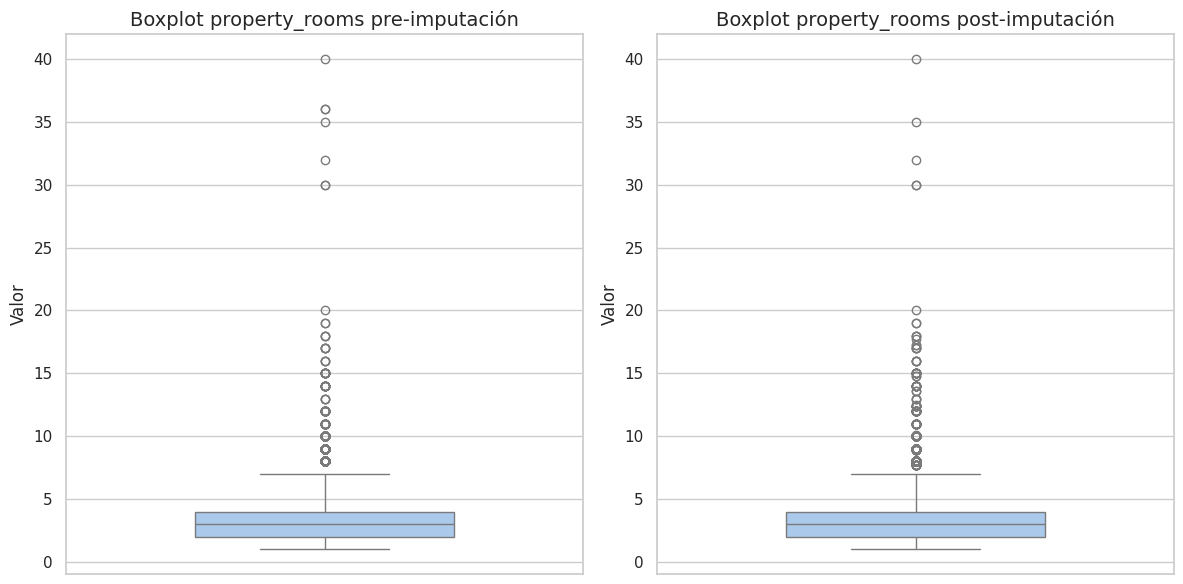

In [95]:
generar_distribucion("property_rooms")

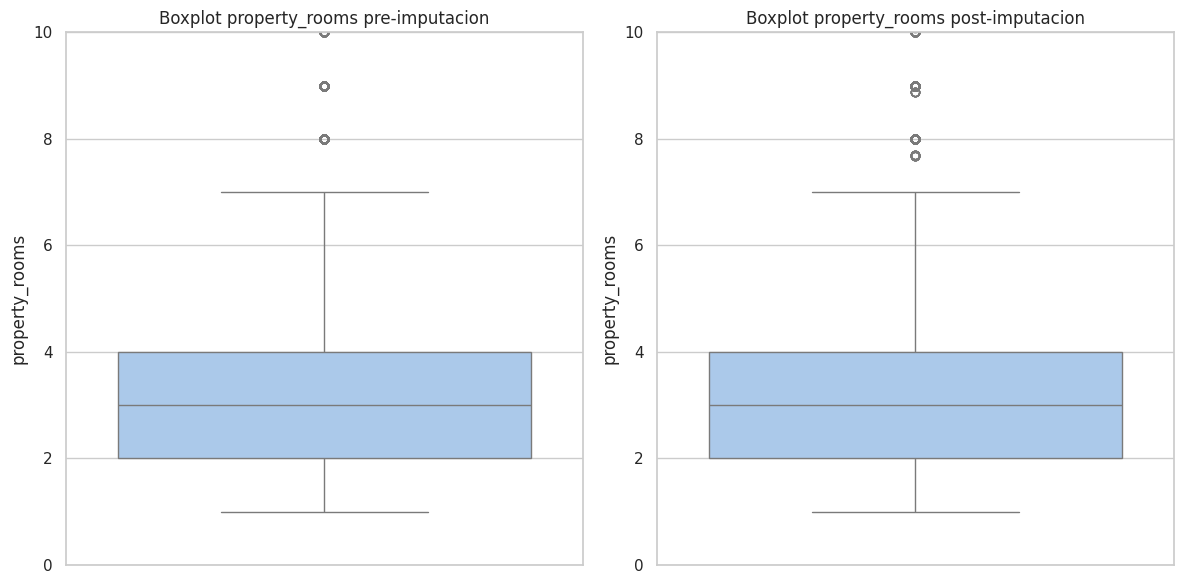

In [96]:
generar_distribucion_zoom("property_rooms")

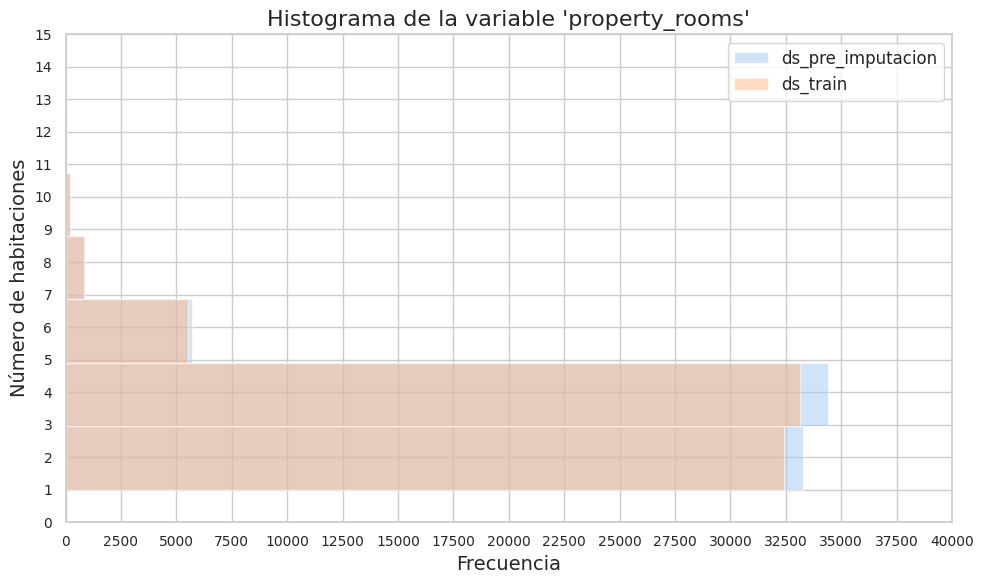

In [97]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Histograma para ds_pre_imputacion en el eje y (invertido)
plt.hist(ds_pre_imputacion['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_pre_imputacion')

# Histograma para ds_train en el eje y (invertido)
plt.hist(ds_train['property_rooms'], bins=20, alpha=0.5, orientation='horizontal', label='ds_train')

# Ajustes de título y etiquetas
plt.title("Histograma de la variable 'property_rooms'", fontsize=16)
plt.xlabel("Frecuencia", fontsize=14)
plt.ylabel("Número de habitaciones", fontsize=14)

# Ajustes de límites de los ejes (zoom)
plt.ylim(0, 15)
plt.xlim(0, 40000)

# Establecer intervalos del eje x
plt.xticks(np.arange(0, 40001, 2500), fontsize=10)

# Añadir leyenda
plt.legend(fontsize=12)

# Establecer intervalos del eje y
plt.yticks(np.arange(16), fontsize=10)

plt.tight_layout()
plt.show()

<Axes: xlabel='property_rooms'>

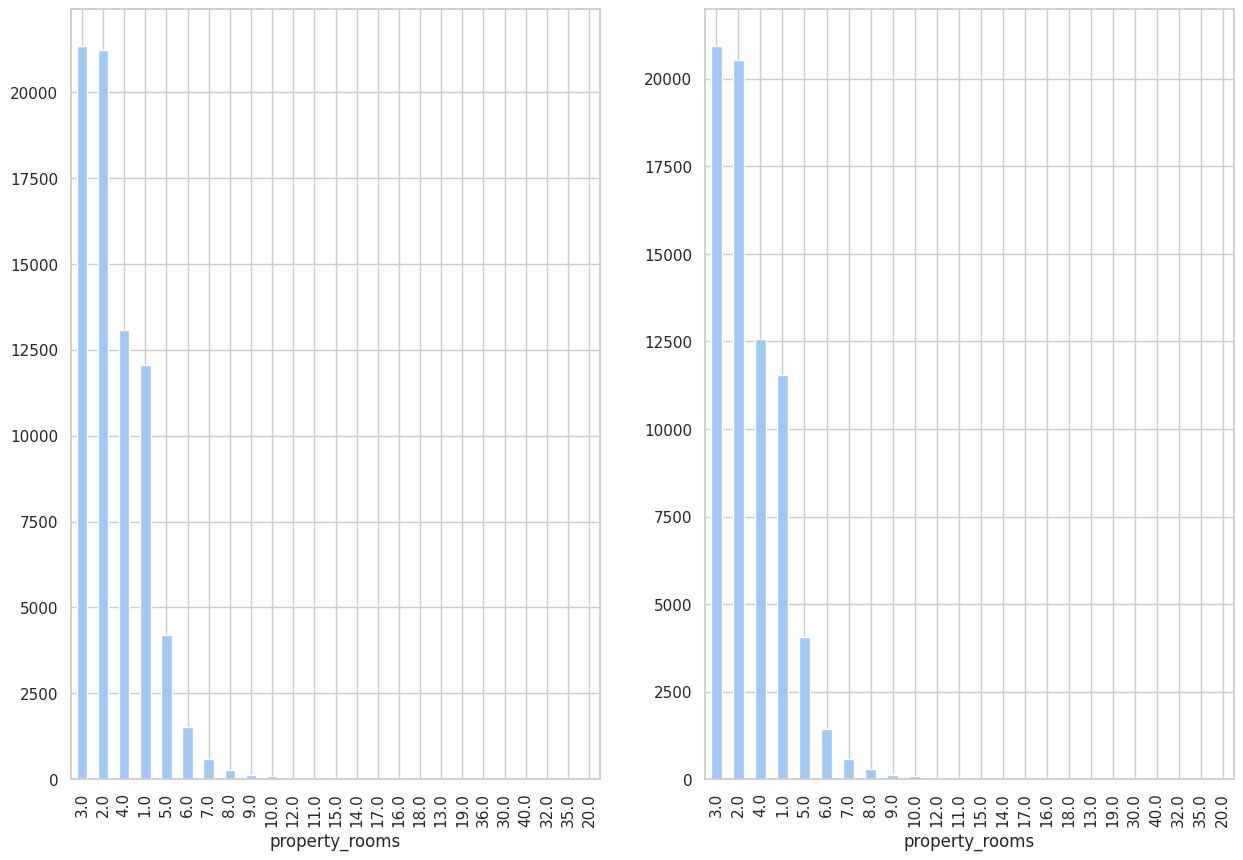

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
ds_pre_imputacion["property_rooms"].value_counts().plot.bar(ax=axes[0])
ds_train["property_rooms"].round().value_counts().plot.bar(ax=axes[1])

A través de estos gráficos, se observan sutiles discrepancias al asignar la cantidad de habitaciones a la hora de realizar la imputación.

In [99]:
pre_rooms = obtener_cantidad_variables(ds_pre_imputacion,'property_rooms')
pre_rooms.head()

,property_rooms,cantidad
0,3.0,21341
1,2.0,21210
2,4.0,13079
3,1.0,12068
4,5.0,4192


In [100]:
post_rooms = obtener_cantidad_variables(ds_train,'property_rooms')
post_rooms.head()

,property_rooms,cantidad
0,3.0,20567
1,2.0,20450
2,4.0,12464
3,1.0,11537
4,5.0,3987


In [101]:
comparar_imputacion(pre_rooms,post_rooms,'property_rooms')

774 registros se imputaron con el valor de 3.0 property_rooms
760 registros se imputaron con el valor de 2.0 property_rooms
615 registros se imputaron con el valor de 4.0 property_rooms
531 registros se imputaron con el valor de 1.0 property_rooms
205 registros se imputaron con el valor de 5.0 property_rooms
100 registros se imputaron con el valor de 6.0 property_rooms
44 registros se imputaron con el valor de 7.0 property_rooms
8 registros se imputaron con el valor de 8.0 property_rooms
2 registros se imputaron con el valor de 9.0 property_rooms
4 registros se imputaron con el valor de 10.0 property_rooms
0 registros se imputaron con el valor de 12.0 property_rooms
0 registros se imputaron con el valor de 11.0 property_rooms
0 registros se imputaron con el valor de 15.0 property_rooms
0 registros se imputaron con el valor de 14.0 property_rooms
6 registros se imputaron con el valor de 17.0 property_rooms
6 registros se imputaron con el valor de 16.0 property_rooms
4 registros se imput

Podemos inferir que la mayoría de los valores faltantes en la variable "property_rooms" fueron sustituidos por la cantidad de dos habitaciones.

#### Comparación property_surface_total

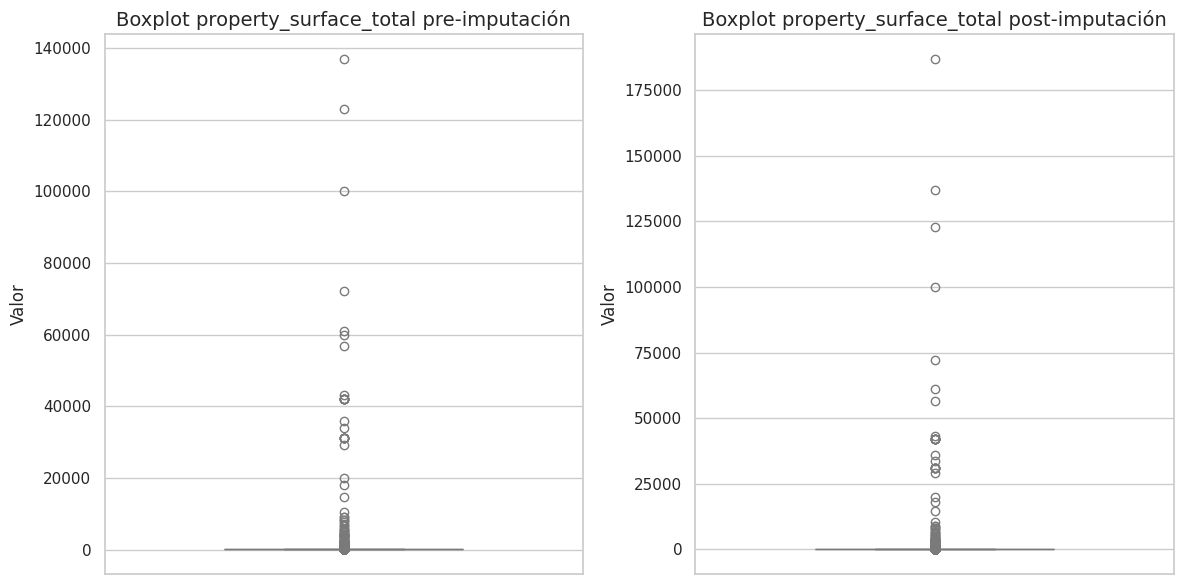

In [102]:
generar_distribucion("property_surface_total")

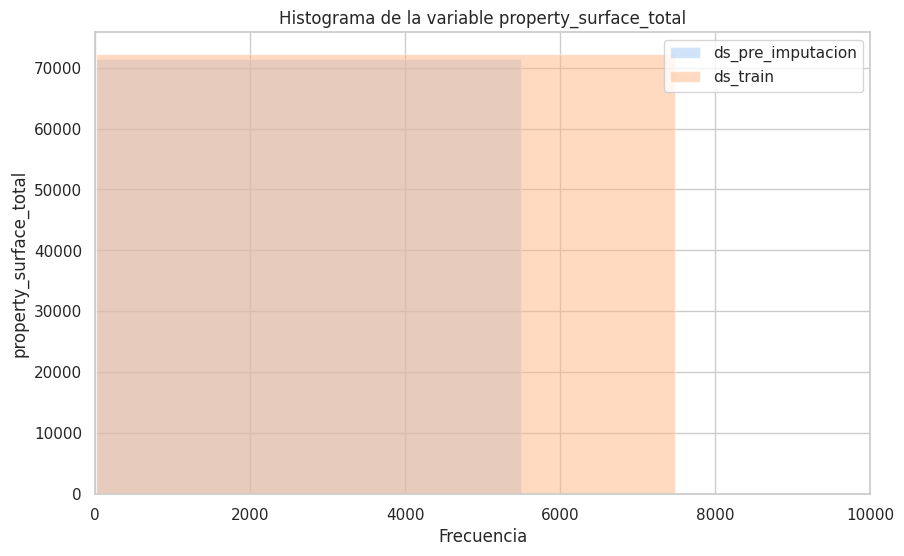

In [103]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_total'], bins=25, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['property_surface_total'], bins=25, alpha=0.5, label='ds_train')

plt.title("Histograma de la variable property_surface_total")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_total")

plt.xlim(0, 10000)

plt.legend()

plt.show()

Observamos una notable disparidad en la cantidad de datos faltantes antes de la imputación de la variable "superficie total".

In [104]:
pre_total = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_total')
pre_total.head()

,property_surface_total,cantidad
0,50.0,1455
1,40.0,1401
2,45.0,1261
3,42.0,1237
4,60.0,1218


In [105]:
post_total = obtener_cantidad_variables(ds_train,'property_surface_total')
post_total.head()

,property_surface_total,cantidad
0,50.0,1378
1,40.0,1362
2,45.0,1214
3,42.0,1192
4,60.0,1166


In [106]:
comparar_imputacion(pre_total,post_total,'property_surface_total')

77 registros se imputaron con el valor de 50.0 property_surface_total
39 registros se imputaron con el valor de 40.0 property_surface_total
47 registros se imputaron con el valor de 45.0 property_surface_total
45 registros se imputaron con el valor de 42.0 property_surface_total
52 registros se imputaron con el valor de 60.0 property_surface_total
52 registros se imputaron con el valor de 38.0 property_surface_total
49 registros se imputaron con el valor de 35.0 property_surface_total
40 registros se imputaron con el valor de 55.0 property_surface_total
36 registros se imputaron con el valor de 44.0 property_surface_total
43 registros se imputaron con el valor de 36.0 property_surface_total
33 registros se imputaron con el valor de 37.0 property_surface_total
45 registros se imputaron con el valor de 43.0 property_surface_total
55 registros se imputaron con el valor de 34.0 property_surface_total
43 registros se imputaron con el valor de 48.0 property_surface_total
37 registros se impu

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_total" fueron reemplazados con una superficie total de 73 m²


#### Comparación property_surface_covered

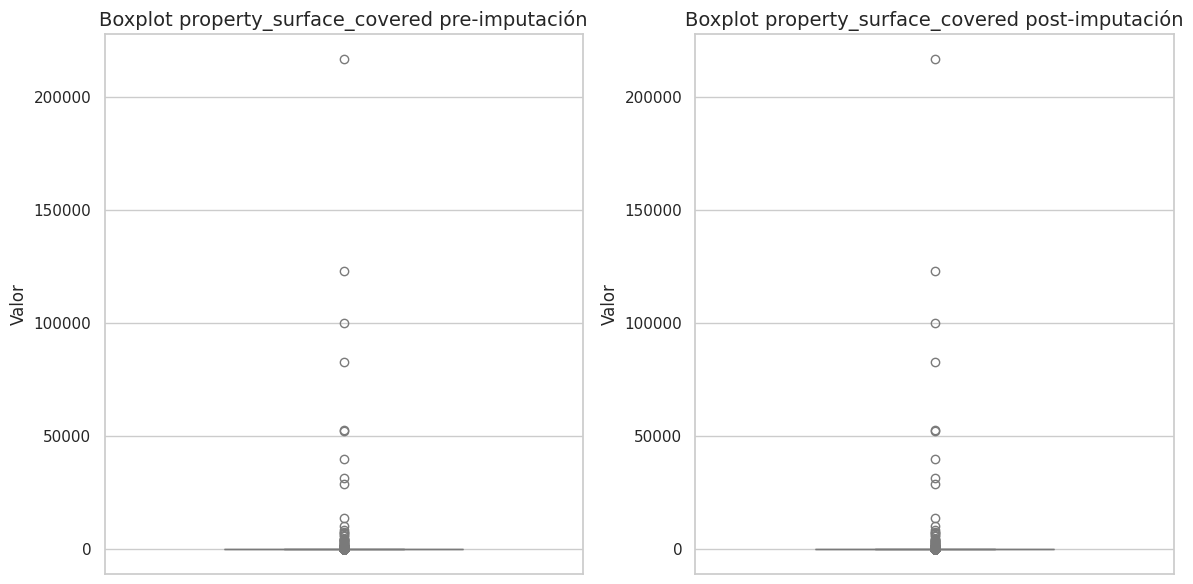

In [107]:
generar_distribucion("property_surface_covered")

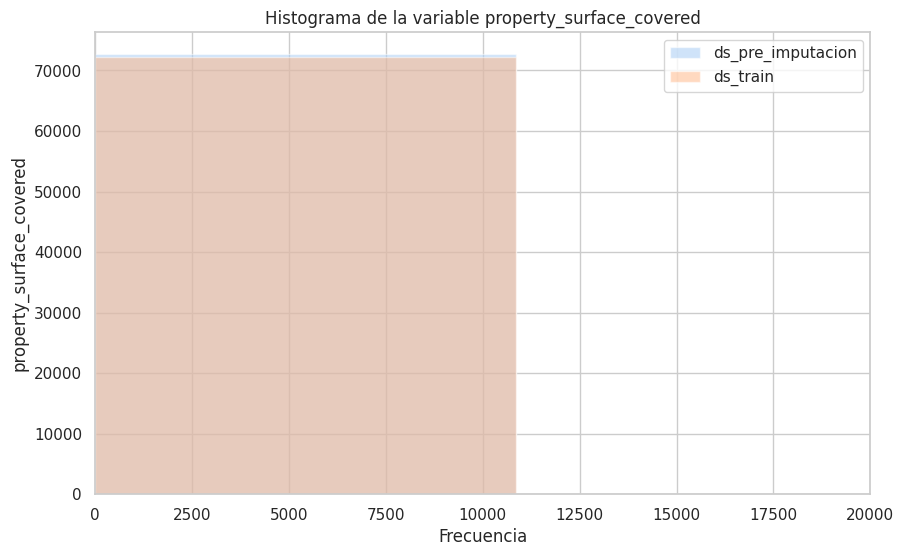

In [108]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['property_surface_covered'], bins=20, alpha=0.5,  label='ds_pre_imputacion')

plt.hist(ds_train['property_surface_covered'], bins=20, alpha=0.5,  label='ds_train')


plt.title("Histograma de la variable property_surface_covered")
plt.xlabel("Frecuencia")
plt.ylabel("property_surface_covered")


plt.xlim(0,20000)

plt.legend()

plt.show()

Se observa una ligera disparidad en los datos faltantes. Se puede inferir que se imputaron pocos datos para la variable "property_surface_covered", ya que esta variable tenía entre los menos valores nulos.

In [109]:
pre_cubierto = obtener_cantidad_variables(ds_pre_imputacion,'property_surface_covered')
pre_cubierto.head()

,property_surface_covered,cantidad
0,40.0,1950
1,38.0,1634
2,50.0,1582
3,45.0,1573
4,35.0,1465


In [110]:
post_cubierto = obtener_cantidad_variables(ds_train,'property_surface_covered')
post_cubierto.head()

,property_surface_covered,cantidad
0,40.0,1896
1,38.0,1556
2,50.0,1532
3,45.0,1508
4,35.0,1410


In [111]:
comparar_imputacion(pre_cubierto,post_cubierto,'property_surface_covered')

54 registros se imputaron con el valor de 40.0 property_surface_covered
78 registros se imputaron con el valor de 38.0 property_surface_covered
50 registros se imputaron con el valor de 50.0 property_surface_covered
65 registros se imputaron con el valor de 45.0 property_surface_covered
55 registros se imputaron con el valor de 35.0 property_surface_covered
44 registros se imputaron con el valor de 42.0 property_surface_covered
51 registros se imputaron con el valor de 60.0 property_surface_covered
52 registros se imputaron con el valor de 37.0 property_surface_covered
56 registros se imputaron con el valor de 30.0 property_surface_covered
53 registros se imputaron con el valor de 32.0 property_surface_covered
45 registros se imputaron con el valor de 36.0 property_surface_covered
58 registros se imputaron con el valor de 34.0 property_surface_covered
59 registros se imputaron con el valor de 33.0 property_surface_covered
41 registros se imputaron con el valor de 43.0 property_surface_

Podemos concluir que la mayoría de los valores faltantes en la variable "property_surface_covered" fueron completados con una superficie cubierta de 78 m²

#### Comparación latitud

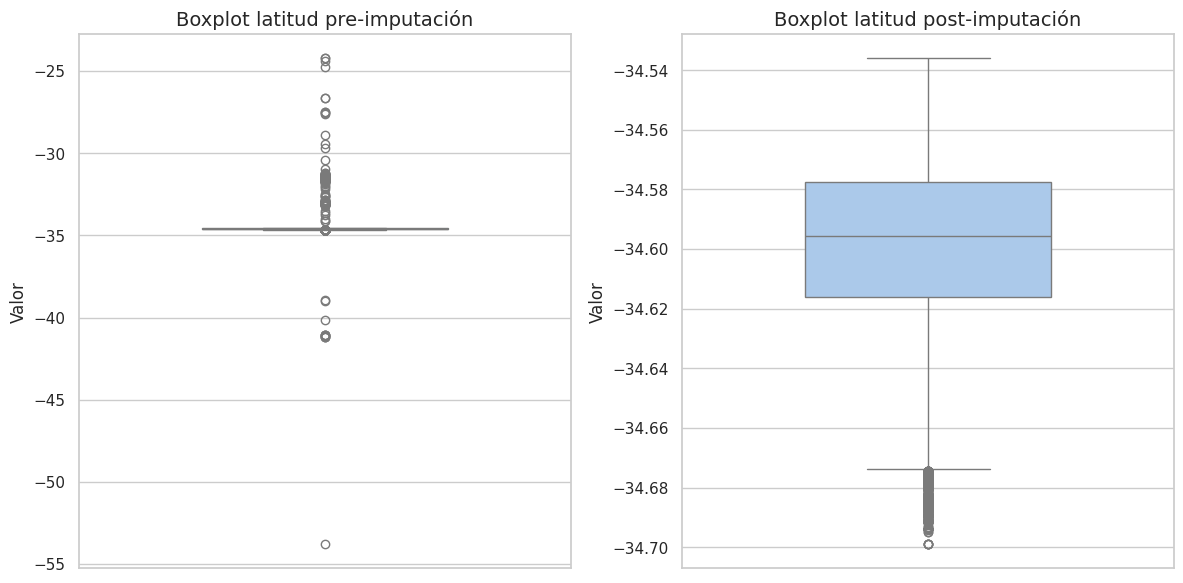

In [112]:
generar_distribucion("latitud")

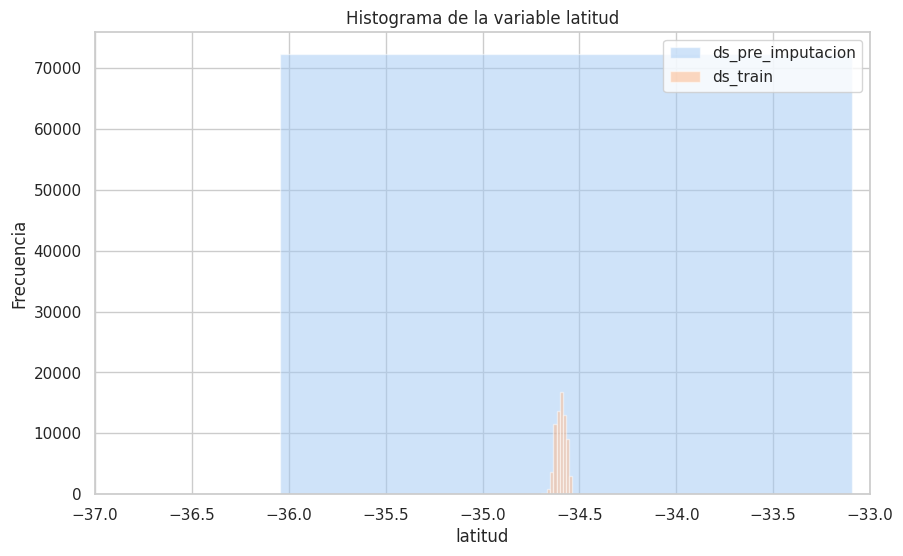

In [113]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['latitud'], bins=10, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['latitud'], bins=10, alpha=0.5, label='ds_train')

plt.xlim(-37, -33)

plt.title("Histograma de la variable latitud")
plt.xlabel("latitud")
plt.ylabel("Frecuencia")

plt.legend()

plt.show()

Se puede observar que antes de la imputación, la latitud tenía una frecuencia constante para todos sus valores. Sin embargo, al imputar los datos, la frecuencia varía más, generando una distribución en forma de campana de Gauss. Se destaca que la latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -34.58.

In [114]:
pre_latitud = obtener_cantidad_variables(ds_pre_imputacion,'latitud')
pre_latitud

,latitud,cantidad
0,-34.541250,115
1,-34.619406,95
2,-34.604538,92
3,-34.541616,80
4,-34.581910,80
...,...,...
39272,-34.542421,1
39273,-34.631057,1
39274,-34.611054,1
39275,-34.555146,1


In [115]:
post_latitud = obtener_cantidad_variables(ds_train,'latitud')
post_latitud

,latitud,cantidad
0,-34.541250,115
1,-34.619406,95
2,-34.604538,92
3,-34.581910,80
4,-34.541616,80
...,...,...
39134,-34.620662,1
39135,-34.604061,1
39136,-34.635644,1
39137,-34.639709,1


Parecieran ser iguales... pero lo hemos imputado

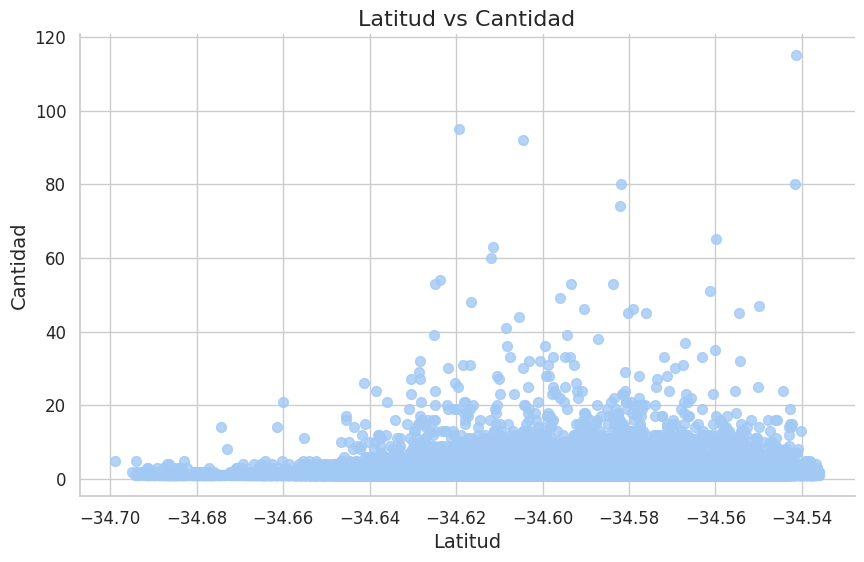

In [116]:
# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_latitud['latitud'], post_latitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Latitud vs Cantidad", fontsize=16)
plt.xlabel("Latitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [117]:
pre_latitud.equals(post_latitud)

False

In [118]:
print(len(pre_latitud))
print(len(post_latitud))
print('diferencia: {}'.format(len(pre_latitud)-len(post_latitud)))

39277
39139
diferencia: 138


#### Comparación longitud

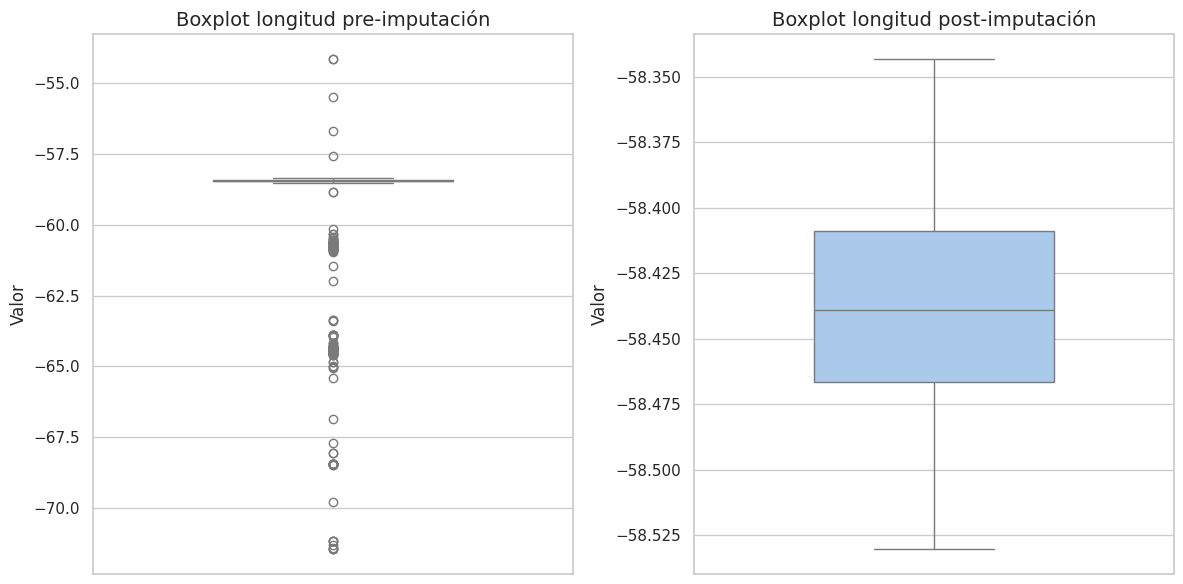

In [119]:
generar_distribucion("longitud")

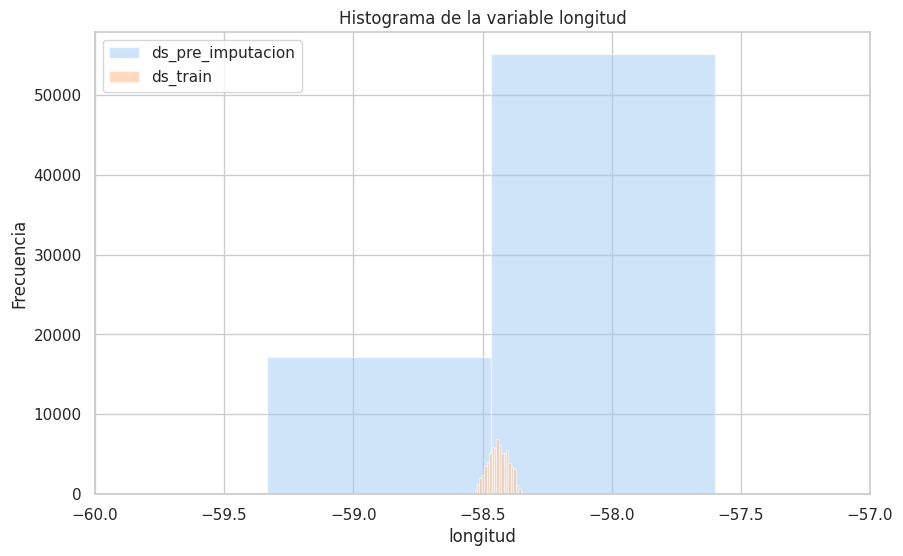

In [120]:
plt.figure(figsize=(10, 6))

plt.hist(ds_pre_imputacion['longitud'], bins=20, alpha=0.5, label='ds_pre_imputacion')

plt.hist(ds_train['longitud'], bins=20, alpha=0.5, label='ds_train')


plt.title("Histograma de la variable longitud")
plt.xlabel("longitud")
plt.ylabel("Frecuencia")

plt.xlim(-60, -57)

plt.legend()

plt.show()

Todos los valores que se mencionarán en el siguiente párrafo se consideran aproximados.

Antes de la imputación, se observa que la latitud tenía una frecuencia medianamente constante. Desde la latitud -59.5 hasta -58.5, la frecuencia es de aproximadamente 18000, luego aumenta en más de 50000 hasta llegar a la latitud -57.5.

Tras la imputación de los datos, se observa una variación en la frecuencia que genera una distribución en forma de campana de Gauss. La latitud aproximada con la máxima cantidad de datos nulos completos es alrededor de -58.400.

In [121]:
pre_longitud = obtener_cantidad_variables(ds_pre_imputacion,'longitud')
pre_longitud.head()

,longitud,cantidad
0,-58.472966,115
1,-58.451999,95
2,-58.424956,92
3,-58.473377,80
4,-58.449381,80


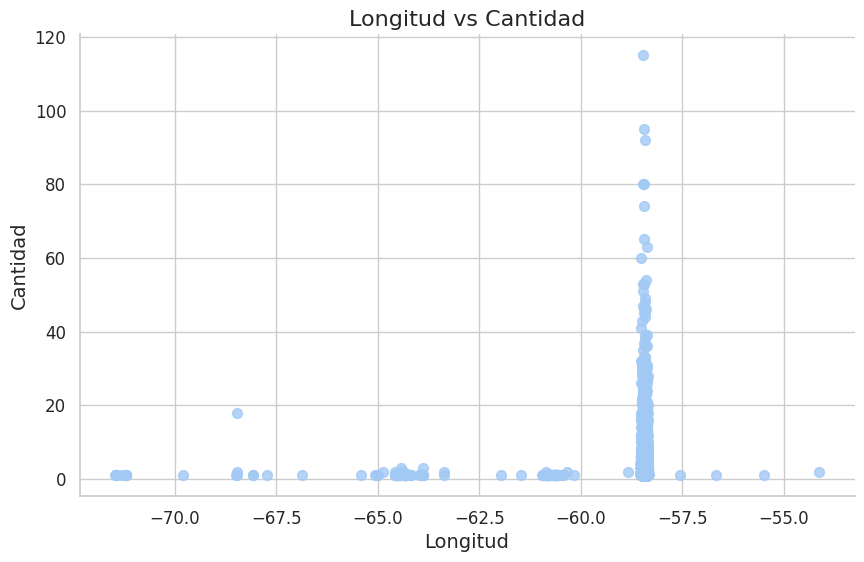

In [122]:
# @title longitud vs cantidad

# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(pre_longitud['longitud'], pre_longitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Longitud vs Cantidad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [123]:
post_longitud = obtener_cantidad_variables(ds_train,'longitud')
post_longitud.head()

,longitud,cantidad
0,-58.472966,115
1,-58.451999,95
2,-58.424956,92
3,-58.449381,80
4,-58.473377,80


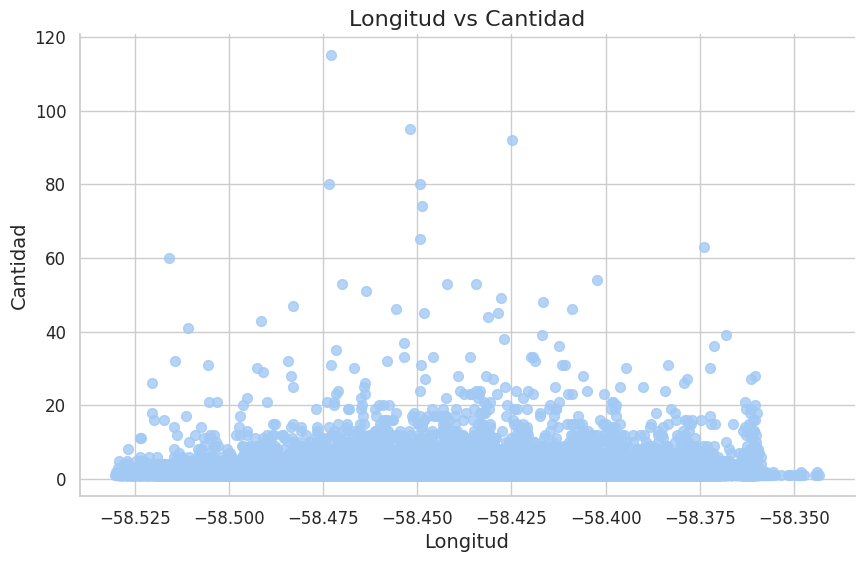

In [124]:
# @title longitud vs cantidad

# Configuración de estilo y colores
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(post_longitud['longitud'], post_longitud['cantidad'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Longitud vs Cantidad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Cantidad", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [125]:
pre_longitud.equals(post_longitud)

False

In [126]:
print(len(pre_longitud))
print(len(post_longitud))
print('diferencia: {}'.format(len(pre_longitud)-len(post_longitud)))

39067
38929
diferencia: 138


#### Comparación place_l3

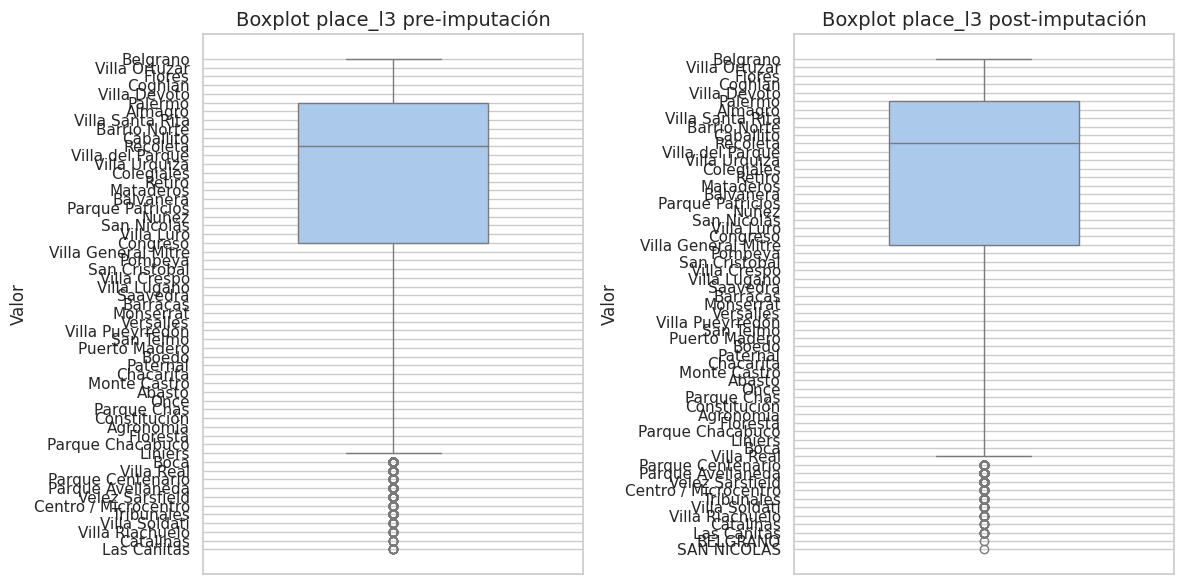

In [127]:
generar_distribucion("place_l3")

Se observa que antes de la imputación, el barrio con mayor cantidad de propiedades era San Cristóbal, mientras que después de la imputación, la media ha cambiado y ahora es Villa Urquiza. No obstante, Palermo continúa siendo el barrio con la mayor cantidad de propiedades en ambos casos.

In [128]:
pre_barrio = obtener_cantidad_variables(ds_pre_imputacion,'place_l3')
pre_barrio.head()

,place_l3,cantidad
0,Palermo,11470
1,Belgrano,7167
2,Caballito,5744
3,Recoleta,5014
4,Villa Urquiza,3770


In [129]:
post_barrio = obtener_cantidad_variables(ds_train,'place_l3')
post_barrio.head()

,place_l3,cantidad
0,Palermo,10744
1,Belgrano,6637
2,Caballito,5606
3,Recoleta,4833
4,Villa Urquiza,3648


In [130]:
comparar_imputacion(pre_barrio,post_barrio,'place_l3')

726 registros se imputaron con el valor de Palermo place_l3
530 registros se imputaron con el valor de Belgrano place_l3
138 registros se imputaron con el valor de Caballito place_l3
181 registros se imputaron con el valor de Recoleta place_l3
122 registros se imputaron con el valor de Villa Urquiza place_l3
129 registros se imputaron con el valor de Almagro place_l3
192 registros se imputaron con el valor de Nuñez place_l3
92 registros se imputaron con el valor de Villa Crespo place_l3
98 registros se imputaron con el valor de Flores place_l3
144 registros se imputaron con el valor de Barrio Norte place_l3
62 registros se imputaron con el valor de Balvanera place_l3
6 registros se imputaron con el valor de Colegiales place_l3
7 registros se imputaron con el valor de Villa Devoto place_l3
6 registros se imputaron con el valor de Saavedra place_l3
9 registros se imputaron con el valor de Villa del Parque place_l3
51 registros se imputaron con el valor de Puerto Madero place_l3
51 regist

Podemos concluir que la mayoría de los valores faltantes en la variable "place_l3" fueron completados con el nombre del barrio "Palermo".

## Valores atípicos

# Agrupamiento
En este punto se busca analizar si es posible agrupar los datos en función de algún criterio.

## Clustering
Analizar la tendencia al clustering del dataset.

In [131]:
ds_train.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
163099,s/xi1+gUfkb5CNmtGt0VXg==,2021-11-28,2021-12-31,2021-11-28,-34.566931,-58.462353,Capital Federal,Belgrano,Departamento,3.0,2.0,75.0,66.813762,175000.0
194657,m5LwwT9lblHRC6gQ4hUtLA==,2021-08-21,2022-02-09,2021-08-21,-34.590769,-58.468700,Capital Federal,Villa Ortuzar,PH,4.0,3.0,214.0,128.000000,310000.0
370716,tLFTDJdArx8jXfr56Xp36A==,2021-04-24,2021-08-23,2021-04-24,-34.620609,-58.469621,Capital Federal,Flores,PH,4.0,3.0,162.0,120.000000,170000.0
447149,iXnJelKuXCWWtKhorAOo1g==,2021-05-22,2021-06-05,2021-05-22,-34.560864,-58.480387,Capital Federal,Coghlan,Departamento,1.0,1.0,43.0,37.000000,99000.0
430837,t9EE5qtZjeI9qOYrXQzKUg==,2021-12-16,2022-02-09,2021-12-16,-34.600820,-58.520193,Capital Federal,Villa Devoto,Departamento,3.0,2.0,74.0,60.000000,185000.0


Para agrupar, podemos dejar de lado las columnas 'place_l2' y 'place_l3', ya que podemos completar los datos necesarios para realizar el clustering utilizando las columnas de latitud y longitud. Además, podemos eliminar la columna 'id', ya que generalmente solo sirve como un identificador único para cada fila y no es una característica relevante para el clustering. Similarmente, podemos descartar cualquier información relacionada con fechas, ya que no es necesaria para nuestro análisis de clustering.

In [132]:
ds_cluster_train = ds_train.copy()
ds_cluster_test = ds_test.copy()

columnas_a_eliminar = ['place_l2','place_l3','id','start_date','end_date','created_on']
ds_cluster_train.drop(columns = columnas_a_eliminar,inplace=True)
ds_cluster_test.drop(columns = columnas_a_eliminar,inplace=True)

In [133]:
ds_cluster_train.head()

,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
163099,-34.566931,-58.462353,Departamento,3.0,2.0,75.0,66.813762,175000.0
194657,-34.590769,-58.468700,PH,4.0,3.0,214.0,128.000000,310000.0
370716,-34.620609,-58.469621,PH,4.0,3.0,162.0,120.000000,170000.0
447149,-34.560864,-58.480387,Departamento,1.0,1.0,43.0,37.000000,99000.0
430837,-34.600820,-58.520193,Departamento,3.0,2.0,74.0,60.000000,185000.0


<ipython-input-134-0ae634a64398>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ds_cluster_train, x='longitud', y='property_type', inner='box', palette=palette)
<ipython-input-134-0ae634a64398>:11: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(ds_cluster_train, x='longitud', y='property_type', inner='box', palette=palette)


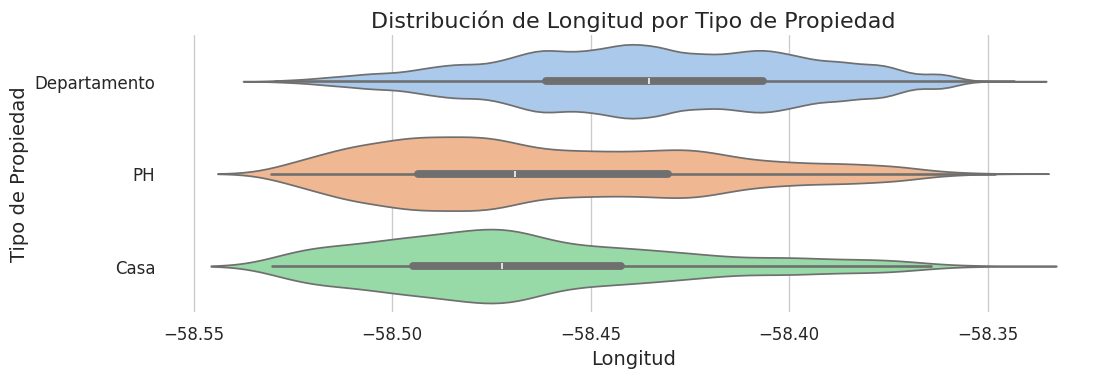

In [134]:
# @title property_type vs longitud
# Configuración de estilo y paleta de colores
sns.set(style="whitegrid")
palette = sns.color_palette("pastel")

# Ajuste del tamaño de la figura
figsize = (12, 1.2 * len(ds_cluster_train['property_type'].unique()))
plt.figure(figsize=figsize)

# Creación del gráfico de violín
sns.violinplot(ds_cluster_train, x='longitud', y='property_type', inner='box', palette=palette)

# Eliminación de los ejes
sns.despine(top=True, right=True, bottom=True, left=True)

# Ajustes de título y etiquetas
plt.title("Distribución de Longitud por Tipo de Propiedad", fontsize=16)
plt.xlabel("Longitud", fontsize=14)
plt.ylabel("Tipo de Propiedad", fontsize=14)

# Ajuste del tamaño de fuente de las etiquetas
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

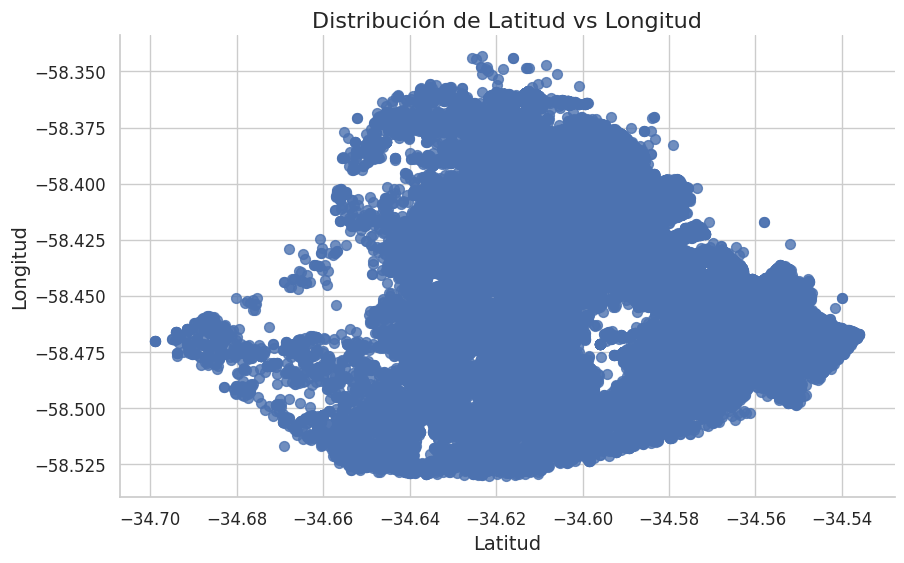

In [135]:
# @title latitud vs longitud

# Configuración de la figura y los ejes
plt.figure(figsize=(10, 6))

# Creación del gráfico de dispersión
plt.scatter(ds_cluster_train['latitud'], ds_cluster_train['longitud'], s=50, alpha=0.8)

# Ajustes del título y etiquetas
plt.title("Distribución de Latitud vs Longitud", fontsize=16)
plt.xlabel("Latitud", fontsize=14)
plt.ylabel("Longitud", fontsize=14)

# Ocultar los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar tamaño de fuente de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [136]:
ds_cluster_test.head()

,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
422132,-34.567537,-58.436881,Departamento,3.0,2.0,111.0,94.0,315000.0
233867,-34.598702,-58.496876,Departamento,2.0,1.0,41.0,39.0,93000.0
150593,-34.639597,-58.369096,Departamento,2.0,1.0,118.0,111.0,179900.0
218610,-34.595960,-58.396517,Departamento,2.0,1.0,40.0,40.0,95000.0
385819,-34.607370,-58.441696,Departamento,2.0,1.0,45.0,45.0,78000.0


Vamos a realizar una transformación de variables para trabajar con todos datos numéricos. En este caso, vamos a utilizar la regresión logística para la variable proterty_type

In [137]:
ds_cluster_train = pd.get_dummies(ds_cluster_train, columns=["property_type"])
ds_cluster_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Casa,property_type_Departamento,property_type_PH
163099,-34.566931,-58.462353,3.0,2.0,75.0,66.813762,175000.0,False,True,False
194657,-34.590769,-58.468700,4.0,3.0,214.0,128.000000,310000.0,False,False,True
370716,-34.620609,-58.469621,4.0,3.0,162.0,120.000000,170000.0,False,False,True
447149,-34.560864,-58.480387,1.0,1.0,43.0,37.000000,99000.0,False,True,False
430837,-34.600820,-58.520193,3.0,2.0,74.0,60.000000,185000.0,False,True,False


In [138]:
ds_cluster_test = pd.get_dummies(ds_cluster_test, columns=["property_type"])
ds_cluster_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Casa,property_type_Departamento,property_type_PH
422132,-34.567537,-58.436881,3.0,2.0,111.0,94.0,315000.0,False,True,False
233867,-34.598702,-58.496876,2.0,1.0,41.0,39.0,93000.0,False,True,False
150593,-34.639597,-58.369096,2.0,1.0,118.0,111.0,179900.0,False,True,False
218610,-34.595960,-58.396517,2.0,1.0,40.0,40.0,95000.0,False,True,False
385819,-34.607370,-58.441696,2.0,1.0,45.0,45.0,78000.0,False,True,False


Aplico máximos y minimos para el dataset

In [139]:
def aplicar_max_min(ds, columnas):
    scaler = MinMaxScaler()
    for columna in columnas:
        ds[[columna]] = scaler.fit_transform(ds[[columna]])

aplicar_max_min(ds_cluster_train,columnas_con_numeros)

## Grupos
Estimar la cantidad apropiada de grupos que se deben formar.

Para ello vamos a utilizar la Regla del codo (Elbow Method).

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

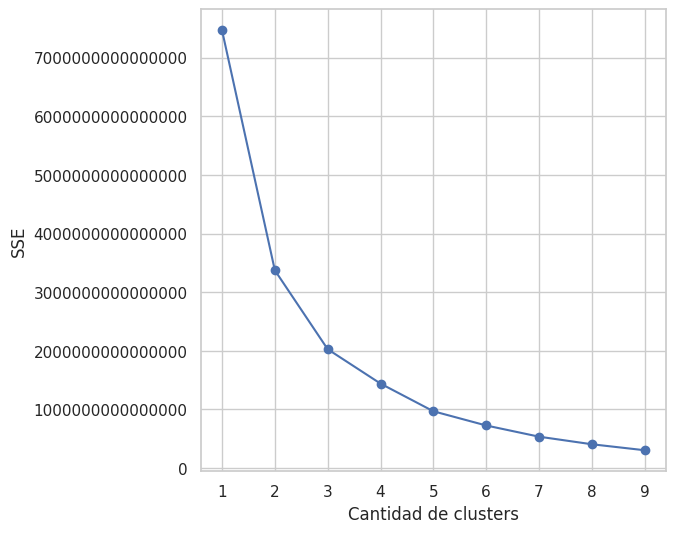

In [140]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(ds_cluster_train)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')

# Desactivar la notación científica en el eje y
plt.ticklabel_format(style='plain', axis='y')

plt.show()

Al ver el gráfico no tenemos un codo pronunciadamente. Entonces verificamos la cantidad de conjuntos a elegir con el método de Silhouette.

## Grupos con Silhouette <font color='red'> REVISAR </font>
Evaluar la calidad de los grupos formados realizando un análisis de Silhouette

In [141]:
list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(ds_cluster_train)

    score = silhouette_score (ds_cluster_train, preds)
    print ("\n\nFor n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




For n_clusters =2 silhouette score is 0.8961686580767398


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




For n_clusters =3 silhouette score is 0.7926205658489607


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




For n_clusters =4 silhouette score is 0.7193943610063437


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(




For n_clusters =5 silhouette score is 0.6957988153596294


## Análisis de grupo
Realizar un análisis de cada grupo intentando entender en función de qué características
fueron formados.

## Mapa de CABA
Graficar sobre un mapa de CABA los avisos coloreados según el grupo al que pertenecen.

## Análisis con tres grupos
Repetir el análisis anterior, utilizando sólo 3 grupos.